## Подгрузка библиотек

In [618]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import vrplib
import time

## Просмотр структуры

In [619]:
instance = vrplib.read_instance("Set/B/B-n45-k6.vrp")
solution = vrplib.read_solution("Set/B/B-n45-k6.sol")
instance

{'name': 'B-n45-k6',
 'comment': '(Augerat et al, No of trucks: 6, Optimal value: 678)',
 'type': 'CVRP',
 'dimension': 45,
 'edge_weight_type': 'EUC_2D',
 'capacity': 100,
 'node_coord': array([[ 49,  64],
        [ 60,  38],
        [ 38,  21],
        [ 98,  27],
        [ 69,  60],
        [ 59,  40],
        [ 82,  28],
        [ 86,  36],
        [ 76,  65],
        [102,  29],
        [ 43,  26],
        [ 45,  28],
        [ 76,  68],
        [ 64,  45],
        [  0,  44],
        [ 89,  31],
        [ 60,  44],
        [  0,  44],
        [ 84,  29],
        [ 83,  66],
        [ 86,  36],
        [103,  32],
        [ 76,  65],
        [ 86,  74],
        [  0,  48],
        [ 66,  41],
        [ 67,  40],
        [ 77,  61],
        [ 78,  66],
        [ 66,  46],
        [ 61,  41],
        [105,  31],
        [ 78,  68],
        [ 91,  37],
        [ 83,  29],
        [ 91,  45],
        [ 42,  25],
        [ 83,  69],
        [101,  36],
        [ 74,  65],
        [ 93,

In [620]:
solution

{'routes': [[1, 11, 10, 36, 2, 14, 17, 24],
  [16, 25, 26, 6, 34, 18, 29],
  [5, 30, 42, 13, 43],
  [44, 33, 40, 9, 3, 15, 7, 20],
  [39, 8, 22, 28, 32, 23, 37, 19, 27, 4],
  [21, 31, 41, 38, 35, 12]],
 'cost': 678}

## Реализация алгоритма

### Функции для генетического алгоритма

In [621]:
def initialize_population(num_points, population_size):
    """
    Инициализация начальной популяции.

    Входные параметры:
      num_points: общее количество вершин в задаче
      population_size: размер популяции, который нужно создать (количество маршрутов)

    Выходные параметры:
      population: созданные маршруты
    """
    # Без депо
    base = list(range(1, num_points))
    population = []
    
    for _ in range(population_size):
        random.shuffle(base)
        population.append([0] + base + [0])
        
    return population

In [622]:
def split_routes(individual, demand, capacity, depot):
    """
    Разделение маршрута на несколько подмаршрутов с учетом вместимости в транспортное средство.

    Входные параметры:
      individual: решение задачи CVRP, представленное в виде последовательности точек
      demand: масса грузов для каждой точки
      capacity: максимальная вместимсть транспортного средства
      depot: индекс депо

    Выходные параметры:
      routes: маршрут, разбитый на подмаршруты
    """
    routes = [] # Список для хранения всех подмаршрутов
    route = []  # Список для текущего подмаршрута
    current_load = 0 # Переменная для отслеживания текущего груза на транспортном средстве

    for customer in individual[1:]:
        if customer == depot:
            if route:
                routes.append(route) # Добавляем текущий маршрут в общий список
                route = []
                current_load = 0
        elif current_load + demand[customer] <= capacity: # проверка возможности добавить в подмаршрут еще одного клиента
            route.append(customer)
            current_load += demand[customer]
        else:
            routes.append(route)
            route = [customer]
            current_load = demand[customer]
    if route:
        routes.append(route)
    
    return routes

In [623]:
def cost_route(routes, dist_matrix, depot):
    """
    Вычисление стоимости маршрута.

    Входные параметры:
      individual: решение задачи CVRP, (маршрут подмаршрутов)
      demand: масса грузов для каждой точки
      capacity: максимальная вместимсть транспортного средства
      depot: индекс депо

    Выходные параметры:
      total_cost: итоговая стоимость для маршрута
    """
    total_cost = 0

    for route in routes:
        full_route = [depot] + route + [depot]
        total_cost += sum(dist_matrix[full_route[i]][full_route[i + 1]] for i in range(len(full_route) - 1))
    
    return total_cost

In [624]:
def select(population, dist_matrix, demand, capacity, depot, selection_rate):
    """
    Отбор лучших маршрутов.

    Входные параметры:
      population: текущий список маршрутов
      dist_matrix: матрица стоимости
      demand: масса грузов для каждой точки
      capacity: максимальная вместимсть транспортного средства
      depot: индекс депо
      selection_rate: доля лучших маршрутов, которые нужно отобрать
    
    Выходные параметры:
      total_cost: итоговая стоимость для маршрута
    """
    
    population.sort(key=lambda individual: cost_route(
        split_routes(individual, demand, capacity, depot), 
        dist_matrix,
        depot
    ))

    return population[:int(len(population) * selection_rate)]

In [625]:
def mutate(individual, mutation_rate):
    """
    Случайная мутация.

    Входные параметры:
      individual: решение задачи CVRP, представленное в виде последовательности точек
      mutation_rate: вероятность мутации
    """
    if random.random() < mutation_rate:
        # Выбираем случайную мутацию
        # swap - меняем два случайных местами
        # move - удаление вершины и добавление ее в другое место
        # invert - меняем последовательность генов в определенной части на обратную
        mutation_type = random.choice(["swap", "move", "invert"])
        
        if mutation_type == "swap":
            idx1, idx2 = random.sample(range(1, len(individual) - 1), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

        elif mutation_type == "move":
            idx1, idx2 = random.sample(range(1, len(individual) - 1), 2)
            element = individual.pop(idx1)
            individual.insert(idx2, element)
        
        elif mutation_type == "invert":
            start, end = sorted(random.sample(range(1, len(individual) - 1), 2))
            individual[start:end] = individual[start:end][::-1]

In [626]:
def ordered_crossover(parent1, parent2):
    """
    Упорядоченный кроссовер. Возвращает двух потомков с депо в начале и в конце.

    Входные параметры:
      parent1: первый родитель, представленное в виде последовательности точек
      parent2: второй родитель, представленное в виде последовательности точек
    
    Выходные параметры:
      child1: первый потомок, представленное в виде последовательности точек
      child2: второй потомок, представленное в виде последовательности точек
    """
    size = len(parent1) - 2
    
    # Выбираем две точки для кроссовера
    a, b = sorted(random.sample(range(1, size + 1), 2))

    # Создаем двух детей с пустыми местами
    child1 = [None] * (size + 2)
    child2 = [None] * (size + 2)

    # Копируем сегмент из первого родителя
    child1[a : b + 1] = parent1[a : b + 1]
    child2[a : b + 1] = parent2[a : b + 1]
    
    # Индексы для заполнения
    index = list(range(b + 1, size + 1)) + list(range(1, a))

    par1 = parent1[b+1:-1] + parent1[1:b+1]
    par1 = np.array(par1)[~np.isin(np.array(par1), np.array(child2[a:b+1]))]
    par2 = parent2[b+1:-1] + parent2[1:b+1]
    par2 = np.array(par2)[~np.isin(np.array(par2), np.array(child1[a:b+1]))]

    if len(index) != 0:
        child1 = np.array(child1)
        child2 = np.array(child2)
        child1[index] = par2
        child2[index] = par1
        
    # Возвращаем депо в начало и конец потомков
    child1[0], child1[-1] = parent1[0], parent1[-1]
    child2[0], child2[-1] = parent2[0], parent2[-1]

    return list(child1), list(child2)

In [627]:
def genetic_algorithm(instance, population_size, generations, selection_rate, mutation_rate, crossover_prob):
    """
    Генетический алгоритм.

    Входные параметры:
      instance: описание задачи CVRP 
      population_size: размер популяции (количество маршрутов)
      generations: количество поколений, которые нужно создать
      selection_rate: доля индивидов, отбираемых для размножения
      mutation_rate: вероятность мутации для потомков
      crossover_prob: вероятность для скрещивания

    Выходные параметры:
      best_routes: лучший, найденный маршрут
      best_cost: стоимость, найденного маршрута
    """
    
    coords = instance['node_coord'] # Координаты вершин
    dist_matrix = instance['edge_weight'] # Матрица расстояний между вершинами
    demand = instance['demand'] # Масса грузов для каждой точки
    capacity = instance['capacity'] # Максимальная вместимость транспортного средства
    depot = instance['depot'][0] # Индекс депо

    num_points = len(coords)
    
    # Создание начальной популяции
    population = initialize_population(num_points, population_size)

    # Создание новых поколений
    for current_generation in range(generations):

        # Отбор лучших маршрутов в популяции
        population = select(population, dist_matrix, demand, capacity, depot, selection_rate)
        next_population = [] # Потомки
        
        while len(next_population) + len(population) < population_size:
            
            parent1, parent2 = random.sample(population, 2)
                
            if random.random() > crossover_prob:
                child1, child2 = parent1, parent2
            else:
                child1, child2 = ordered_crossover(parent1, parent2)  # Кроссовер с двумя потомками
            
            mutate(child1, mutation_rate)  # Мутация первого потомка
            mutate(child2, mutation_rate)  # Мутация второго потомка
            
            next_population.extend([child1, child2])  # Добавляем обоих потомков в список
            
        population.extend(next_population) # Добавляем потомков в популяцию

    best_individual = min(population, key=lambda individual: cost_route(
        split_routes(individual, demand, capacity, depot),
        dist_matrix, 
        depot))
    
    best_routes = split_routes(best_individual, demand, capacity, depot)
    best_cost = cost_route(best_routes, dist_matrix, depot)
    
    return best_routes, best_cost

In [628]:
def solve_vrp(instance, method, params):
    """
    Решение задачи CVRP
    """
    if method == 'gen':
        return genetic_algorithm(instance, params["population_size"], params["generations"], params["selection_rate"], params["mutation_rate"], params["crossover_prob"])
    else:
        raise ValueError(f"Неизвестный метод: {method}")

### Функции проверки

In [629]:
def check_capacity(optimized_routes, instance):
    """
    Проверка, что все подмаршруты удовлетворяют вместимости.

    Входные параметры:
      optimized_routes: решение задачи CVRP, (маршрут подмаршрутов)
      instance: описание задачи CVRP 
      
    Выходные параметры:
      True/False - найден/не найден маршрут, который не удовлетворят вместимости
    """
    
    demand = instance['demand']
    capacity = instance['capacity']
    
    for route in optimized_routes:
        total_demand = sum(demand[customer] for customer in route)
        if total_demand > capacity:
            return True   # если хотя бы один маршрут не удовлетворяет вместимости
            
    return False # Если все маршруты удовлетворяют вместимости

In [630]:
def all_routes_unique(optimized_routes, max_expected_customer):
    """
    Проверка, что все вершины во всех маршрутах уникальны, и выводит повторяющиеся вершины с их индексами.
    Также находит недостающие вершины.

    Входные параметры:
      optimized_routes: решение задачи CVRP, (маршрут подмаршрутов)
      max_expected_customer: количество вершин, которые должны присутствовать в маршруте
      
    Выходные параметры:
      True/False - не найдены/найдены дубликаты в маршруте
    """
    
    all_customers = []
    
    for route_idx, route in enumerate(optimized_routes):
        for customer_idx, customer in enumerate(route):
            all_customers.append((customer, route_idx, customer_idx))  # Сохраняем вершину с её маршрутом и индексом
    
    duplicates = {}
    
    for customer, route_idx, customer_idx in all_customers:
        if customer in duplicates:
            duplicates[customer].append((route_idx, customer_idx))  # Добавляем информацию о повторении
        else:
            duplicates[customer] = [(route_idx, customer_idx)]
            
    found_duplicates = False
    
    for customer, occurrences in duplicates.items():
        if len(occurrences) > 1:  # Проверяем, есть ли дубликаты
            found_duplicates = True
            print(f"Вершина {customer} встречается:")
            for route_idx, customer_idx in occurrences:
                print(f"в маршруте {route_idx} индекс {customer_idx}")
    
    expected_customers = set(range(1, max_expected_customer))
    
    existing_customers = set(duplicates.keys())
    missing_customers = expected_customers - existing_customers
    
    if missing_customers:
        print("Недостающие вершины: ", missing_customers)

    return not found_duplicates  # Возвращаем True, если дубликатов нет

### Функции для локальной оптимизации

In [631]:
def swap_vertices_between_routes(route1, route2, idx1, idx2):
    """
    Меняет местами вершины между двумя маршрутами.
        
    Входные параметры:
      route1: первый подмаршрут
      route2: второй подмаршрут
      idx1: первый индекс
      idx2: второй индекс

    Выходные параметры:
      new_route1: измененный первый подмаршрут с новой вершиной
      new_route2: измененный второй подмаршрут с новой вершиной
    """
    new_route1 = route1[:]
    new_route2 = route2[:]
    new_route1[idx1], new_route2[idx2] = new_route2[idx2], new_route1[idx1]
    return new_route1, new_route2

def can_add_to_route(route, old_customer, new_customer, demand, capacity):
    """
    Проверка возможности добавления вершины в маршрут с учетом вместимости.

    Входные параметры:
      route: подмаршрут
      old_customer: вершина, которую исключают
      new_customer: вершина, которую добавляют
      demand: масса грузов для каждой точки
      capacity: максимальная вместимсть транспортного средства

    Выходные параметры:
      True/False: возможность изменить маршрут
    """
    current_load = sum(demand[cust] for cust in route) - demand[old_customer] + demand[new_customer]
    
    return current_load <= capacity
        
def optimize_routes_with_capacity(generated_routes, instance):
    """
    Оптимизация маршрутов с учетом:
      1. Перестановки вершин между двумя маршрутами.
      2. Перекрещивания ребер между двумя маршрутами.
      3. Передачи вершины между маршрутами.

    Входные параметры:
      generated_routes: список маршрутов
      dist_matrix: матрица расстояний между точками
      demand: список масс грузов для каждой точки
      capacity: вместимость транспортного средства
      depot: индекс депо

    Выходные параметры:
      optimized_routes: список оптимизированных маршрутов
    """
    dist_matrix = instance['edge_weight'] # Матрица расстояний между вершинами
    demand = instance['demand'] # Масса грузов для каждой точки
    capacity = instance['capacity'] # Максимальная вместимость транспортного средства
    depot = instance['depot'][0] # Индекс депо

    improved = True
    optimized_routes = generated_routes[:]

    while improved:
        improved = False

        # Перебираем пары маршрутов
        for i in range(len(optimized_routes)):
            for j in range(len(optimized_routes)):
                if i >= j:
                    continue  # Не сравниваем маршрут с самим собой

                route1, route2 = optimized_routes[i], optimized_routes[j]

                # Обмен вершинами между подмаршрутами
                for idx1, customer1 in enumerate(route1):
                    for idx2, customer2 in enumerate(route2):
                        # Проверяем вместимость
                        if (can_add_to_route(route1, route1[idx1], route2[idx2], demand, capacity) and
                                can_add_to_route(route2, route2[idx2], route1[idx1], demand, capacity)):
                            
                            new_route1, new_route2 = swap_vertices_between_routes(route1, route2, idx1, idx2)

                            # Проверяем стоимость после перестановки
                            cost_before = cost_route([route1], dist_matrix, depot) + cost_route([route2], dist_matrix, depot)
                            cost_after = cost_route([new_route1], dist_matrix, depot) + cost_route([new_route2], dist_matrix, depot)

                            if cost_after < cost_before:
                                optimized_routes[i] = new_route1
                                optimized_routes[j] = new_route2
                                improved = True

                # Перекрещивание ребер
                for k in range(1, len(route1) - 1):
                    for l in range(1, len(route2) - 1):  
                        
                        new_route1 = route1[:k] + route2[l:]
                        new_route2 = route2[:l] + route1[k:]

                        if (can_add_to_route(new_route1, 0, 0, demand, capacity) and
                                can_add_to_route(new_route2, 0, 0, demand, capacity)):
                            
                            cost_before = cost_route([route1], dist_matrix, depot) + cost_route([route2], dist_matrix, depot)
                            cost_after = cost_route([new_route1], dist_matrix, depot) + cost_route([new_route2], dist_matrix, depot)

                            if cost_after < cost_before:
                                optimized_routes[i] = new_route1
                                optimized_routes[j] = new_route2
                                improved = True

                # Перенос вершин из подмаршрута в подмаршрут
                for idx1 in range(len(route1)):
                    customer = route1[idx1]
                    if can_add_to_route(route2, 0, customer, demand, capacity):

                        new_route1 = route1[:idx1] + route1[idx1 + 1:]
                        new_route2 = route2 + [customer]

                        cost_before = cost_route([route1], dist_matrix, depot) + cost_route([route2], dist_matrix, depot)
                        cost_after = cost_route([new_route1], dist_matrix, depot) + cost_route([new_route2], dist_matrix, depot)

                        if cost_after < cost_before:
                            optimized_routes[i] = new_route1
                            optimized_routes[j] = new_route2
                            improved = True

    optimized_cost = cost_route(optimized_routes, dist_matrix, depot)
                                    
    return optimized_routes, optimized_cost

## Подбор параметров, нахождение средних результатов и сохранение результатов тестов в словарь

In [632]:
def evaluate_instances(folder_paths, method='gen', param_grid=None, num_test=1):
    """
    Оценка всех экземпляров в заданных папках и подбор параметров, минимизирующих общее среднее отклонение.

    Входные параметры:
      folder_paths: папка с наборами
      method: метод решения
      param_grid: список словарей с параметрами
    """
    best_params = None
    best_avg_deviation = float('inf')
    best_avg_deviation_opt = float('inf')
    all_result = {}

    # Перебор параметров из param_grid
    for params in param_grid:
        print(params)
        cur_result = {"params": params}
        # Засекаем время начала
        start_time = time.time()
        
        overall_deviations = []
        overall_deviations_opt = []

        ar_time = [0, 0, 0]
        num = 0
        for folder_path in folder_paths:
            
            files = [f for f in os.listdir(folder_path) if (f.endswith('.vrp')) and (f not in {"E-n31-k7.vrp", "E-n13-k4.vrp"})]
            folder_deviations = []
            folder_deviations_opt = []

            for file in files:
                result_file = {}
                
                instance = vrplib.read_instance(os.path.join(folder_path, file))
                solution = vrplib.read_solution(os.path.join(folder_path, file.replace('.vrp', '.sol')))
                
                optimal_cost = solution['cost']

                start_time_gen = time.time()
                generated_routes, generated_cost = solve_vrp(instance, method, params)
                end_time_gen = time.time()

                # Оптимизация маршрутов
                check_gen = check_capacity(generated_routes, instance)
                if check_gen:
                    print("Ошибка-генерация: один или несколько маршрутов превышают вместимость!")

                if not all_routes_unique(generated_routes, instance["dimension"]):
                    print("Ошибка: есть дублирующиеся вершины в маршрутах! ", generated_routes)
                
                # Оптимизация маршрутов
                start_time_opt = time.time()
                optimized_routes, optimized_cost  = optimize_routes_with_capacity(generated_routes, instance)
                end_time_opt = time.time()
                #print("Опт: ", optimized_cost, "До: ", generated_cost)
            
                check_opt = check_capacity(optimized_routes, instance)
                if check_opt:
                    print("Ошибка-оптимизация: один или несколько маршрутов превышают вместимость!")

                if not all_routes_unique(optimized_routes, instance["dimension"]):
                    print("Ошибка: есть дублирующиеся вершины в маршрутах! ", optimized_routes)
                    
                #print(f"Оптимальная стоиомсть: {optimal_cost:.2f} , Полученная: {generated_cost:.2f}, Оптимизированное: {optimized_cost:.2f}")
                #print(f"Оптимальный маршрут: {solution['routes']},\n полученный: {generated_routes},\n Оптимизированное: {optimized_routes}")

                # Расчет отклонения
                deviation = (abs(generated_cost - optimal_cost) / optimal_cost) * 100
                deviation_opt = (abs(optimized_cost - optimal_cost) / optimal_cost) * 100
                folder_deviations.append(deviation)
                folder_deviations_opt.append(deviation_opt)
                ar_time[num] += (end_time_opt - start_time_gen)

                result_file.update({
                    "capacity": instance["capacity"],
                    "node_coord": instance["node_coord"],
                    "demand": instance["demand"],
                    "depot": instance['depot'][0],
                    "edge_weight": instance['edge_weight'],
                    "routes": solution["routes"],
                    "cost": optimal_cost,
                    "generated_routes": generated_routes,
                    "generated_cost": generated_cost,
                    "generated_time": end_time_gen - start_time_gen,
                    "optimized_routes": optimized_routes,
                    "optimized_cost": optimized_cost,
                    "optimized_time": end_time_opt - start_time_opt,
                    "deviation": deviation,
                    "deviation_opt": deviation_opt
                })
                
                cur_result[file] = result_file
                
            # Среднее отклонение для текущего набора
            if folder_deviations:
                avg_folder_deviation = np.mean(folder_deviations)
                overall_deviations.extend(folder_deviations)
                avg_folder_deviation_opt = np.mean(folder_deviations_opt)
                overall_deviations_opt.extend(folder_deviations_opt)
                print(f"Среднее отклонение в папке {folder_path}: {avg_folder_deviation:.2f}%, Оптимизированное: {avg_folder_deviation_opt:.2f}%")
                print(f"Среднее время поиска маршрута для папки {folder_path}: {ar_time[num]/len(files)}") 
            num += 1

        all_result[f"Тест №{num_test}"] = cur_result
        num_test += 1
        
        # Среднее отклонение по всем наборам
        avg_overall_deviation = np.mean(overall_deviations)
        avg_overall_deviation_opt = np.mean(overall_deviations_opt)

        print(f"Текущие параметры: {params}")
        print(f"Среднее отклонение с этими параметрами: {avg_overall_deviation:.2f}%, Оптимизированное: {avg_overall_deviation_opt:.2f}%")

        end_time = time.time()
        execution_time = end_time - start_time
        
        print(f"Время выполнения: {execution_time} секунд")

        # Проверяем, является ли текущее отклонение лучшим
        if avg_overall_deviation < best_avg_deviation:
            best_avg_deviation = avg_overall_deviation
            best_avg_deviation_opt = avg_overall_deviation_opt
            best_params = params
            
    print(f"Лучшие параметры: {best_params}")
    print(f"Общее среднее отклонение с лучшими параметрами: {best_avg_deviation:.2f}%")
    print(f"Общее среднее отклонение с лучшими параметрами оптимизированное: {best_avg_deviation_opt:.2f}%\n")
    
    return best_params, best_avg_deviation, best_avg_deviation_opt, all_result

In [56]:
param_grid_gen = []
for population_size in [200, 300]:
    for generations in [400, 500]:
        for selection_rate in [0.1, 0.3]:
            for mutation_rate in [0.6, 0.9]:
                for crossover_prob in [0.9, 1.0]:
                    param_grid_gen.append({"population_size": population_size, "generations": generations, "selection_rate": selection_rate, "mutation_rate": mutation_rate, "crossover_prob": crossover_prob})
                    

In [57]:
len(param_grid_gen)

32

In [58]:
folder_paths = ["Set/B/", "Set/P/", "Set/E/"]
all_sr = 0
all_sropt = 0
n = 1
for i in range(n):
    best_params, best_avg_deviation, best_avg_deviation_opt, all_result = evaluate_instances(folder_paths, method='gen', param_grid=param_grid_gen, num_test=i+1)  # Генетический алгоритм
    all_sr += best_avg_deviation
    all_sropt += best_avg_deviation_opt
print("Cреднее отклонение полученных решений от оптимальных ", all_sr/n)
print("Cреднее отклонение полученных решений от оптимальных оптим ", all_sropt/n)

{'population_size': 200, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.6, 'crossover_prob': 0.9}
Среднее отклонение в папке Set/B/: 14.13%, Оптимизированное: 8.62%
Среднее время поиска маршрута для папки Set/B/: 2.936991608661154
Среднее отклонение в папке Set/P/: 12.07%, Оптимизированное: 9.37%
Среднее время поиска маршрута для папки Set/P/: 2.8766126732031503
Среднее отклонение в папке Set/E/: 19.80%, Оптимизированное: 13.04%
Среднее время поиска маршрута для папки Set/E/: 3.2602011507207695
Текущие параметры: {'population_size': 200, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.6, 'crossover_prob': 0.9}
Среднее отклонение с этими параметрами: 14.35%, Оптимизированное: 9.77%

Время выполнения: 172.51499915122986 секунд
{'population_size': 200, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.6, 'crossover_prob': 1.0}
Среднее отклонение в папке Set/B/: 9.31%, Оптимизированное: 6.82%
Среднее время поиска маршрута для папки Set/B/: 3.0819281

In [596]:
import pickle

# Загрузка словаря с диска
with open('all_result.pkl', 'rb') as f:
    loaded_result = pickle.load(f)

### Полученные результаты

In [633]:
import pandas as pd
import numpy as np

def create_dataframe_from_results(loaded_result):
    """
    Функция для создания DataFrame из загруженного результата.

    Входные параметры:
        loaded_result: cловарь с результатами тестов

    Выходные параметры:
        DataFrame с обработанными данными
    """
    rows = []

    for test_name, test_data in loaded_result.items():
        params = test_data['params']
        for key, values in test_data.items():
            if key == 'params':
                continue
            if any(key.startswith(prefix) for prefix in ['B', 'P', 'E']):
                rows.append({
                    'test_name': test_name,
                    'file': key,
                    'dimension': len(values['demand']),
                    'population_size': params['population_size'],
                    'generations': params['generations'],
                    'selection_rate': params['selection_rate'],
                    'mutation_rate': params['mutation_rate'],
                    'crossover_prob': params['crossover_prob'],
                    'deviation': values['deviation'],
                    'deviation_opt': values['deviation_opt'],
                    'generated_time': values['generated_time'],
                    'optimized_time': values['optimized_time'],
                    'total_time': values['generated_time'] + values['optimized_time']
                })

    # Создаем DataFrame
    return pd.DataFrame(rows)

In [634]:
def summarize_group(group):
    """
    Функция для группировки и усреднения результатов.

    Входные параметры:
        group: даннные

    Выходные параметры:
        Обработанные данные
    """
    # Групповые параметры, которые одинаковы для всех записей
    summary = {
        'population_size': group['population_size'].iloc[0],
        'generations': group['generations'].iloc[0],
        'selection_rate': group['selection_rate'].iloc[0],
        'mutation_rate': group['mutation_rate'].iloc[0],
        'crossover_prob': group['crossover_prob'].iloc[0],
        'overall_deviation': group['deviation'].mean(),
        'overall_deviation_opt': group['deviation_opt'].mean(),
        'overall_generated_time': group['generated_time'].mean(),
        'overall_optimized_time': group['optimized_time'].mean(),
        'overall_total_time': group['total_time'].mean(),
    }

    # Фильтрация для "B", "P", и "E"
    for prefix in ['B', 'P', 'E']:
        filtered = group[group['file'].str.startswith(prefix)]
        summary.update({
            f'{prefix}_deviation_mean': filtered['deviation'].mean(),
            f'{prefix}_deviation_opt_mean': filtered['deviation_opt'].mean(),
            f'{prefix}_generated_time_mean': filtered['generated_time'].mean(),
            f'{prefix}_optimized_time_mean': filtered['optimized_time'].mean(),
            f'{prefix}_total_time_mean': filtered['total_time'].mean(),
        })

    return pd.Series(summary)

In [635]:
df_result = create_dataframe_from_results(loaded_result)
df_result

,test_name,file,dimension,population_size,generations,selection_rate,mutation_rate,crossover_prob,deviation,deviation_opt,generated_time,optimized_time,total_time
0,Тест №1,B-n34-k5.vrp,34,200,400,0.1,0.6,0.9,3.485573,3.485573,2.412533,0.002732,2.415265
1,Тест №1,B-n45-k5.vrp,45,200,400,0.1,0.6,0.9,3.169498,3.146594,2.604773,0.006878,2.611651
2,Тест №1,B-n64-k9.vrp,64,200,400,0.1,0.6,0.9,16.519941,7.795708,3.338604,0.084746,3.423350
3,Тест №1,B-n68-k9.vrp,68,200,400,0.1,0.6,0.9,22.787018,21.086399,3.464842,0.044829,3.509671
4,Тест №1,B-n38-k6.vrp,38,200,400,0.1,0.6,0.9,2.169757,2.169757,2.401108,0.002672,2.403780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,Тест №32,E-n101-k8.vrp,101,300,500,0.3,0.9,1.0,43.217781,18.264590,7.632155,0.616079,8.248234
1852,Тест №32,E-n23-k3.vrp,23,300,500,0.3,0.9,1.0,0.131125,0.131125,3.090843,0.001736,3.092579
1853,Тест №32,E-n33-k4.vrp,33,300,500,0.3,0.9,1.0,4.477026,4.477026,3.775137,0.002084,3.777221
1854,Тест №32,E-n76-k14.vrp,76,300,500,0.3,0.9,1.0,20.852903,12.442369,6.771300,0.055541,6.826841


In [636]:
result = (
    df_result.groupby('test_name', group_keys=False)
    .apply(summarize_group)
    .reset_index()
    .sort_values(by='overall_deviation')
)
result

/var/folders/0q/xgyn4jwj0fvdbk_12zm1vzhc0000gn/T/ipykernel_81373/3934334794.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


,test_name,population_size,generations,selection_rate,mutation_rate,crossover_prob,overall_deviation,overall_deviation_opt,overall_generated_time,overall_optimized_time,...,P_deviation_mean,P_deviation_opt_mean,P_generated_time_mean,P_optimized_time_mean,P_total_time_mean,E_deviation_mean,E_deviation_opt_mean,E_generated_time_mean,E_optimized_time_mean,E_total_time_mean
20,Тест №28,300.0,500.0,0.1,0.9,1.0,8.236374,6.980257,5.743149,0.030916,...,6.540336,5.775410,5.493663,0.034281,5.527944,10.282436,8.670244,6.213232,0.045997,6.259229
12,Тест №20,300.0,400.0,0.1,0.9,1.0,9.093161,7.131012,4.635584,0.040876,...,7.663464,6.002149,4.535972,0.049765,4.585737,14.722569,10.321246,5.078635,0.071730,5.150365
3,Тест №12,200.0,500.0,0.1,0.9,1.0,9.190342,7.318870,3.871934,0.040812,...,8.010900,7.013191,3.717281,0.039015,3.756296,13.096608,8.398742,4.168412,0.087791,4.256203
18,Тест №26,300.0,500.0,0.1,0.6,1.0,9.201199,8.094473,5.649937,0.030824,...,6.737578,6.085788,5.415675,0.024107,5.439783,11.790448,9.878962,6.157187,0.064860,6.222047
23,Тест №30,300.0,500.0,0.3,0.6,1.0,9.251106,7.479434,5.086392,0.046707,...,8.568775,7.416993,4.953808,0.049817,5.003625,14.168429,10.170861,5.567379,0.095926,5.663305
1,Тест №10,200.0,500.0,0.1,0.6,1.0,9.555785,7.949171,3.826577,0.040244,...,8.188254,7.359523,3.697506,0.037653,3.735158,13.459629,10.548597,4.124250,0.075472,4.199721
11,Тест №2,200.0,400.0,0.1,0.6,1.0,9.623488,7.665362,3.082965,0.041543,...,8.319679,7.125695,2.983080,0.044896,3.027976,13.120989,10.609100,3.351943,0.072260,3.424202
9,Тест №18,300.0,400.0,0.1,0.6,1.0,9.635185,7.738786,4.504370,0.034860,...,8.725298,7.537515,4.350273,0.025461,4.375735,12.026990,9.122172,4.908908,0.078156,4.987064
26,Тест №4,200.0,400.0,0.1,0.9,1.0,9.754388,7.761150,3.123356,0.041253,...,8.136047,6.368302,3.018060,0.048934,3.066994,14.333622,10.835460,3.371019,0.059705,3.430723
8,Тест №17,300.0,400.0,0.1,0.6,0.9,10.245981,7.733529,4.293491,0.042016,...,8.976567,6.967894,4.125010,0.045596,4.170606,13.830253,10.515836,4.657706,0.065607,4.723313


## Тесты для 3-x лучших наборов параметров

## Расчет

In [637]:
param_grid_gen = [{'population_size': 300, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}]
folder_paths = ["Set/B/", "Set/P/", "Set/E/"]
all_sr = 0
all_sropt = 0
dict_res_300_500 = {}
n = 10
for i in range(n):
    best_params, best_avg_deviation, best_avg_deviation_opt, all_result = evaluate_instances(folder_paths, method='gen', param_grid=param_grid_gen, num_test=i+1)  # Генетический алгоритм
    all_sr += best_avg_deviation
    all_sropt += best_avg_deviation_opt
    dict_res_300_500.update(all_result)
print("Cреднее отклонение полученных решений от оптимальных ", all_sr/n)
print("Cреднее отклонение полученных решений от оптимальных оптимизированное", all_sropt/n)

{'population_size': 300, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Среднее отклонение в папке Set/B/: 7.99%, Оптимизированное: 6.84%
Среднее время поиска маршрута для папки Set/B/: 5.867460302684618
Среднее отклонение в папке Set/P/: 7.62%, Оптимизированное: 6.42%
Среднее время поиска маршрута для папки Set/P/: 5.697830190261205
Среднее отклонение в папке Set/E/: 11.34%, Оптимизированное: 9.09%
Среднее время поиска маршрута для папки Set/E/: 6.491206515919078
Текущие параметры: {'population_size': 300, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Среднее отклонение с этими параметрами: 8.47%, Оптимизированное: 7.09%
Время выполнения: 343.1889491081238 секунд
Лучшие параметры: {'population_size': 300, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Общее среднее отклонение с лучшими параметрами: 8.47%
Общее среднее отклонение с лучшими параметрами оптимизирова

In [638]:
import pickle
# Сохранение словаря на диск
with open('all_result_300_500_01_09_01.pkl', 'wb') as f:
    pickle.dump(dict_res_300_500, f)

In [639]:
param_grid_gen = [{'population_size': 300, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}]
folder_paths = ["Set/B/", "Set/P/", "Set/E/"]
all_sr = 0
all_sropt = 0
dict_res_300_400 = {}
n = 10
for i in range(n):
    best_params1, best_avg_deviation1, best_avg_deviation_opt1, all_result1 = evaluate_instances(folder_paths, method='gen', param_grid=param_grid_gen, num_test=i+1)  # Генетический алгоритм
    all_sr += best_avg_deviation1
    all_sropt += best_avg_deviation_opt1
    dict_res_300_400.update(all_result1)
print("Cреднее отклонение полученных решений от оптимальных ", all_sr/n)
print("Cреднее отклонение полученных решений от оптимальных оптимизированное", all_sropt/n)

{'population_size': 300, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Среднее отклонение в папке Set/B/: 7.66%, Оптимизированное: 6.34%
Среднее время поиска маршрута для папки Set/B/: 4.634001130643099
Среднее отклонение в папке Set/P/: 9.12%, Оптимизированное: 7.85%
Среднее время поиска маршрута для папки Set/P/: 4.4576795399188995
Среднее отклонение в папке Set/E/: 14.39%, Оптимизированное: 11.30%
Среднее время поиска маршрута для папки Set/E/: 5.105612017891624
Текущие параметры: {'population_size': 300, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Среднее отклонение с этими параметрами: 9.54%, Оптимизированное: 7.90%
Время выполнения: 269.813285112381 секунд
Лучшие параметры: {'population_size': 300, 'generations': 400, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Общее среднее отклонение с лучшими параметрами: 9.54%
Общее среднее отклонение с лучшими параметрами оптимизиров

In [640]:
import pickle
# Сохранение словаря на диск
with open('all_result_300_400_01_09_01.pkl', 'wb') as f:
    pickle.dump(dict_res_300_400, f)

In [20]:
param_grid_gen = [{'population_size': 200, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}]
folder_paths = ["Set/B/", "Set/P/", "Set/E/"]
all_sr = 0
all_sropt = 0
n = 10
dict_res_200_500 = {}
for i in range(n):
    best_params2, best_avg_deviation2, best_avg_deviation_opt2, all_result2 = evaluate_instances(folder_paths, method='gen', param_grid=param_grid_gen, num_test=i+1)  # Генетический алгоритм
    all_sr += best_avg_deviation2
    all_sropt += best_avg_deviation_opt2
    dict_res_200_500.update(all_result2)
print("Cреднее отклонение полученных решений от оптимальных ", all_sr/n)
print("Cреднее отклонение полученных решений от оптимальных оптимизированное", all_sropt/n)

{'population_size': 200, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Среднее отклонение в папке Set/B/: 7.54%, Оптимизированное: 6.57%
Среднее время поиска маршрута для папки Set/B/: 3.8464382420415464
Среднее отклонение в папке Set/P/: 7.64%, Оптимизированное: 6.51%
Среднее время поиска маршрута для папки Set/P/: 3.764401614665985
Среднее отклонение в папке Set/E/: 12.88%, Оптимизированное: 9.08%
Среднее время поиска маршрута для папки Set/E/: 4.2509473237124356
Текущие параметры: {'population_size': 200, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Среднее отклонение с этими параметрами: 8.60%, Оптимизированное: 7.02%
Время выполнения: 225.63867282867432 секунд
Лучшие параметры: {'population_size': 200, 'generations': 500, 'selection_rate': 0.1, 'mutation_rate': 0.9, 'crossover_prob': 1.0}
Общее среднее отклонение с лучшими параметрами: 8.60%
Общее среднее отклонение с лучшими параметрами оптимизир

In [21]:
# Сохранение словаря на диск
with open('all_result_200_500_01_09_01.pkl', 'wb') as f:
    pickle.dump(dict_res_200_500, f)

### Результаты

In [641]:
def info_dataframe(df):
    """
    Функция вывода информации.

    Входные параметры:
      df: данные
    
    """
    print(f"Текущие параметры:")
    print(f"  population_size = {df['population_size'].mean():.0f}")
    print(f"  generations = {df['generations'].mean():.0f}")
    print(f"  selection_rate = {df['selection_rate'].mean():.1f}")
    print(f"  mutation_rate = {df['mutation_rate'].mean():.1f}")
    print(f"  crossover_prob = {df['crossover_prob'].mean():.1f}")
    
    # Печать информации по папкам B, P, E
    for cur_set in ['B', 'P', 'E']:
        if any(col.startswith(cur_set) for col in df.columns):
            print(f"\nСредние значения для набора {cur_set}:")
            print(f"  Отклонение: {df[f'{cur_set}_deviation_mean'].mean():.2f}%, Оптимизированное: {df[f'{cur_set}_deviation_opt_mean'].mean():.2f}%")
            print(f"  Время работы алгоритма: {df[f'{cur_set}_generated_time_mean'].mean():.2f}")
            print(f"  Время оптимизации: {df[f'{cur_set}_optimized_time_mean'].mean():.2f}")
            print(f"  Общее время работы: {df[f'{cur_set}_total_time_mean'].mean():.2f}")

    print(f"\nСреднее отклонение для наборов: {df['overall_deviation'].mean():.2f}%, Оптимизированное: {df['overall_deviation_opt'].mean():.2f}%")
    print(f"Среднее время работы алгоритма: {df['overall_generated_time'].mean():.2f}")
    print(f"Среднее время оптимизации: {df['overall_optimized_time'].mean():.2f}")
    print(f"Среднее общее время работы: {df['overall_total_time'].mean():.2f}")

In [642]:
# Загрузка словаря с диска
with open('all_result_300_500_01_09_01.pkl', 'rb') as f:
    loaded_result_300_400_01_09_01 = pickle.load(f)
    
df_300_400_01_09_01 = create_dataframe_from_results(loaded_result_300_400_01_09_01)

In [643]:
import pickle

# Загрузка словаря с диска
with open('all_result_300_500_01_09_01.pkl', 'rb') as f:
    loaded_result_300_500_01_09_01 = pickle.load(f)
    
df_300_500_01_09_01 = create_dataframe_from_results(loaded_result_300_500_01_09_01)
df_300_500_01_09_01_mean = (
    df_300_500_01_09_01.groupby('test_name', group_keys=False)
    .apply(summarize_group)
    .reset_index()
    .sort_values(by='overall_deviation')
)
df_300_500_01_09_01_mean

/var/folders/0q/xgyn4jwj0fvdbk_12zm1vzhc0000gn/T/ipykernel_81373/1622322069.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


,test_name,population_size,generations,selection_rate,mutation_rate,crossover_prob,overall_deviation,overall_deviation_opt,overall_generated_time,overall_optimized_time,...,P_deviation_mean,P_deviation_opt_mean,P_generated_time_mean,P_optimized_time_mean,P_total_time_mean,E_deviation_mean,E_deviation_opt_mean,E_generated_time_mean,E_optimized_time_mean,E_total_time_mean
5,Тест №5,300.0,500.0,0.1,0.9,1.0,7.702478,6.507138,5.853515,0.028842,...,6.484751,5.914468,5.680019,0.022519,5.702538,10.819007,8.700104,6.354553,0.059598,6.414151
1,Тест №10,300.0,500.0,0.1,0.9,1.0,7.884251,6.329319,5.808261,0.031169,...,6.728149,5.664655,5.599800,0.026441,5.626241,10.992793,8.475077,6.246701,0.057781,6.304482
7,Тест №7,300.0,500.0,0.1,0.9,1.0,8.329372,7.003763,5.818898,0.036340,...,6.693483,6.089120,5.620637,0.029856,5.650493,11.879420,8.892381,6.311738,0.079548,6.391287
6,Тест №6,300.0,500.0,0.1,0.9,1.0,8.342808,7.159283,5.845296,0.029276,...,6.836800,6.233144,5.600988,0.016608,5.617596,12.556962,9.724511,6.476273,0.076767,6.553040
9,Тест №9,300.0,500.0,0.1,0.9,1.0,8.455535,7.269209,5.789255,0.032490,...,7.058298,6.645623,5.544311,0.025159,5.569471,12.417280,10.001774,6.365926,0.069251,6.435177
0,Тест №1,300.0,500.0,0.1,0.9,1.0,8.468644,7.092769,5.873589,0.041940,...,7.617772,6.422430,5.650403,0.047393,5.697795,11.335235,9.087783,6.414654,0.076507,6.491160
8,Тест №8,300.0,500.0,0.1,0.9,1.0,8.541614,7.385029,5.797445,0.031855,...,7.403063,6.717341,5.584723,0.026439,5.611162,12.270801,10.029956,6.267614,0.071082,6.338697
4,Тест №4,300.0,500.0,0.1,0.9,1.0,8.547686,7.333089,5.822236,0.033893,...,6.923859,6.236470,5.596830,0.034929,5.631759,10.935022,8.506754,6.402322,0.061891,6.464213
3,Тест №3,300.0,500.0,0.1,0.9,1.0,8.560572,7.197002,5.788242,0.032834,...,7.607484,6.972934,5.573754,0.033488,5.607242,12.020247,9.757149,6.281977,0.058364,6.340341
2,Тест №2,300.0,500.0,0.1,0.9,1.0,8.564731,7.205601,5.891949,0.035056,...,7.066017,6.098535,5.646715,0.025133,5.671848,11.118019,8.954757,6.518565,0.079433,6.597998


In [644]:
info_dataframe(df_300_500_01_09_01_mean)

Текущие параметры:
  population_size = 300
  generations = 500
  selection_rate = 0.1
  mutation_rate = 0.9
  crossover_prob = 1.0

Средние значения для набора B:
  Отклонение: 8.12%, Оптимизированное: 6.79%
  Время работы алгоритма: 5.80
  Время оптимизации: 0.02
  Общее время работы: 5.82

Средние значения для набора P:
  Отклонение: 7.04%, Оптимизированное: 6.30%
  Время работы алгоритма: 5.61
  Время оптимизации: 0.03
  Общее время работы: 5.64

Средние значения для набора E:
  Отклонение: 11.63%, Оптимизированное: 9.21%
  Время работы алгоритма: 6.36
  Время оптимизации: 0.07
  Общее время работы: 6.43

Среднее отклонение для наборов: 8.34%, Оптимизированное: 7.05%
Среднее время работы алгоритма: 5.83
Среднее время оптимизации: 0.03
Среднее общее время работы: 5.86


In [645]:
# Загрузка словаря с диска
with open('all_result_300_400_01_09_01.pkl', 'rb') as f:
    loaded_result_300_400_01_09_01 = pickle.load(f)
    
df_300_400_01_09_01 = create_dataframe_from_results(loaded_result_300_400_01_09_01)
df_300_400_01_09_01_mean = (
    df_300_400_01_09_01.groupby('test_name', group_keys=False)
    .apply(summarize_group)
    .reset_index()
    .sort_values(by='overall_deviation')
)
df_300_400_01_09_01_mean

/var/folders/0q/xgyn4jwj0fvdbk_12zm1vzhc0000gn/T/ipykernel_81373/1751494316.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


,test_name,population_size,generations,selection_rate,mutation_rate,crossover_prob,overall_deviation,overall_deviation_opt,overall_generated_time,overall_optimized_time,...,P_deviation_mean,P_deviation_opt_mean,P_generated_time_mean,P_optimized_time_mean,P_total_time_mean,E_deviation_mean,E_deviation_opt_mean,E_generated_time_mean,E_optimized_time_mean,E_total_time_mean
7,Тест №7,300.0,400.0,0.1,0.9,1.0,7.979499,6.405372,4.623044,0.052146,...,7.891072,6.220452,4.490853,0.079150,4.570003,10.710596,7.993888,5.055554,0.063117,5.118672
5,Тест №5,300.0,400.0,0.1,0.9,1.0,8.601884,6.772531,4.610551,0.052535,...,7.877564,6.666235,4.425126,0.066953,4.492078,12.012678,9.273423,5.088176,0.064892,5.153068
8,Тест №8,300.0,400.0,0.1,0.9,1.0,8.703372,7.191326,4.580280,0.036705,...,8.337517,7.328573,4.400710,0.031680,4.432390,11.592472,8.357087,4.938925,0.078282,5.017207
1,Тест №10,300.0,400.0,0.1,0.9,1.0,8.882353,7.501813,4.611944,0.030454,...,8.294486,7.330111,4.438457,0.023460,4.461917,12.491781,10.149327,5.019970,0.058757,5.078727
9,Тест №9,300.0,400.0,0.1,0.9,1.0,9.042661,7.478093,4.588327,0.038263,...,8.011721,7.058048,4.417087,0.038163,4.455250,15.388234,11.364555,5.000479,0.077033,5.077512
4,Тест №4,300.0,400.0,0.1,0.9,1.0,9.332411,7.506367,4.614851,0.038621,...,7.617776,6.466185,4.421138,0.033034,4.454172,14.722223,11.508657,5.149416,0.066817,5.216233
6,Тест №6,300.0,400.0,0.1,0.9,1.0,9.332868,7.278178,4.615449,0.038137,...,8.226537,7.098976,4.448404,0.036122,4.484526,13.008667,9.158756,5.105638,0.075347,5.180984
3,Тест №3,300.0,400.0,0.1,0.9,1.0,9.364694,7.789493,4.603388,0.039971,...,8.270776,7.154287,4.361658,0.039084,4.400742,13.095297,9.513524,4.990696,0.078530,5.069226
0,Тест №1,300.0,400.0,0.1,0.9,1.0,9.541048,7.904145,4.613690,0.036756,...,9.118338,7.846490,4.419075,0.038572,4.457647,14.387678,11.302165,5.044288,0.061273,5.105561
2,Тест №2,300.0,400.0,0.1,0.9,1.0,9.624301,7.707756,4.782576,0.039968,...,7.915496,7.047207,4.726667,0.029679,4.756347,15.161488,9.519884,5.172351,0.109190,5.281541


In [646]:
info_dataframe(df_300_400_01_09_01_mean)

Текущие параметры:
  population_size = 300
  generations = 400
  selection_rate = 0.1
  mutation_rate = 0.9
  crossover_prob = 1.0

Средние значения для набора B:
  Отклонение: 7.95%, Оптимизированное: 6.52%
  Время работы алгоритма: 4.59
  Время оптимизации: 0.02
  Общее время работы: 4.62

Средние значения для набора P:
  Отклонение: 8.16%, Оптимизированное: 7.02%
  Время работы алгоритма: 4.45
  Время оптимизации: 0.04
  Общее время работы: 4.50

Средние значения для набора E:
  Отклонение: 13.26%, Оптимизированное: 9.81%
  Время работы алгоритма: 5.06
  Время оптимизации: 0.07
  Общее время работы: 5.13

Среднее отклонение для наборов: 9.04%, Оптимизированное: 7.35%
Среднее время работы алгоритма: 4.62
Среднее время оптимизации: 0.04
Среднее общее время работы: 4.66


In [647]:
# Загрузка словаря с диска
with open('all_result_200_500_01_09_01.pkl', 'rb') as f:
    loaded_result_200_500_01_09_01 = pickle.load(f)
    
df_200_500_01_09_01 = create_dataframe_from_results(loaded_result_200_500_01_09_01)
df_200_500_01_09_01_mean = (
    df_200_500_01_09_01.groupby('test_name', group_keys=False)
    .apply(summarize_group)
    .reset_index()
    .sort_values(by='overall_deviation')
)
df_200_500_01_09_01_mean

/var/folders/0q/xgyn4jwj0fvdbk_12zm1vzhc0000gn/T/ipykernel_81373/3263712962.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


,test_name,population_size,generations,selection_rate,mutation_rate,crossover_prob,overall_deviation,overall_deviation_opt,overall_generated_time,overall_optimized_time,...,P_deviation_mean,P_deviation_opt_mean,P_generated_time_mean,P_optimized_time_mean,P_total_time_mean,E_deviation_mean,E_deviation_opt_mean,E_generated_time_mean,E_optimized_time_mean,E_total_time_mean
5,Тест №5,200.0,500.0,0.1,0.9,1.0,8.381523,6.562017,3.880953,0.037206,...,7.566073,6.157249,3.737674,0.040831,3.778504,11.088231,8.874421,4.304180,0.072473,4.376653
0,Тест №1,200.0,500.0,0.1,0.9,1.0,8.595719,7.019171,3.849780,0.039409,...,7.640841,6.505918,3.719928,0.044455,3.764383,12.879419,9.079203,4.181902,0.069023,4.250925
4,Тест №4,200.0,500.0,0.1,0.9,1.0,8.890102,7.332472,3.868352,0.044052,...,8.439062,7.278895,3.729533,0.050614,3.780148,11.215268,8.163994,4.229319,0.075142,4.304461
3,Тест №3,200.0,500.0,0.1,0.9,1.0,9.043216,7.440732,3.882539,0.030143,...,8.149875,7.189388,3.748493,0.025059,3.773552,11.880745,9.397718,4.253541,0.059426,4.312967
1,Тест №10,200.0,500.0,0.1,0.9,1.0,9.111937,7.596190,3.888428,0.033267,...,6.613426,5.870182,3.762577,0.027860,3.790437,12.251086,9.166859,4.188307,0.062644,4.250950
2,Тест №2,200.0,500.0,0.1,0.9,1.0,9.227761,7.151296,3.872539,0.031651,...,8.469381,7.095651,3.740625,0.027696,3.768321,10.242750,7.752779,4.256505,0.058191,4.314696
6,Тест №6,200.0,500.0,0.1,0.9,1.0,9.554305,7.529772,3.923626,0.042469,...,7.653427,6.551566,3.796709,0.030923,3.827632,14.902447,10.646330,4.286165,0.106908,4.393073
9,Тест №9,200.0,500.0,0.1,0.9,1.0,9.636456,7.793706,3.898050,0.039321,...,7.940596,7.091819,3.763982,0.033782,3.797764,12.983056,10.206318,4.240579,0.077548,4.318126
8,Тест №8,200.0,500.0,0.1,0.9,1.0,9.648677,8.065099,3.876719,0.036067,...,7.974260,6.798497,3.788152,0.040431,3.828583,12.487675,9.519541,4.216090,0.060936,4.277027
7,Тест №7,200.0,500.0,0.1,0.9,1.0,9.923367,8.012951,3.884494,0.041185,...,8.206086,6.782825,3.771501,0.036629,3.808130,12.704294,9.520228,4.158137,0.078918,4.237056


In [648]:
info_dataframe(df_200_500_01_09_01_mean)

Текущие параметры:
  population_size = 200
  generations = 500
  selection_rate = 0.1
  mutation_rate = 0.9
  crossover_prob = 1.0

Средние значения для набора B:
  Отклонение: 9.13%, Оптимизированное: 7.35%
  Время работы алгоритма: 3.85
  Время оптимизации: 0.02
  Общее время работы: 3.87

Средние значения для набора P:
  Отклонение: 7.87%, Оптимизированное: 6.73%
  Время работы алгоритма: 3.76
  Время оптимизации: 0.04
  Общее время работы: 3.79

Средние значения для набора E:
  Отклонение: 12.26%, Оптимизированное: 9.23%
  Время работы алгоритма: 4.23
  Время оптимизации: 0.07
  Общее время работы: 4.30

Среднее отклонение для наборов: 9.20%, Оптимизированное: 7.45%
Среднее время работы алгоритма: 3.88
Среднее время оптимизации: 0.04
Среднее общее время работы: 3.92


## Построение графиков

In [697]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_column_by_dimension(df, column_name, x_lab, tit_lab):
    """
    Строит графики зависимости заданного столбца от размера задачи.

    Входные параметры:
      df: датафрейм
      column_name: имя столбца для анализа
      x_lab: название оси X
      tit_lab: заголовок для графика
    """
    grouped = df.groupby(['file', 'dimension'], as_index=False).mean()
    
    groups = {
        'B': grouped[grouped['file'].str.startswith('B')],
        'E': grouped[grouped['file'].str.startswith('E')],
        'P': grouped[grouped['file'].str.startswith('P')]
    }
    
    colors = {'B': 'lime', 'E': 'pink', 'P': 'royalblue'}
    markers = {'B': '.', 'E': '8', 'P': '*'}

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Левый график: группы B, E, P
    for key, group in groups.items():
        group = group.drop(columns=['file']).groupby('dimension', as_index=False).mean()

        axs[0].plot(group['dimension'], group[column_name], label=f'Набор {key}',
                    color=colors[key], marker=markers[key], linewidth=2)
        axs[0].scatter(group['dimension'], group[column_name], color=colors[key],
                       marker=markers[key], s=50)

    axs[0].set_title(f"Зависимость {tit_lab} решения от размера задачи по наборам", fontsize=14)
    axs[0].set_xlabel(f"Размерность задачи", fontsize=10)
    axs[0].set_ylabel(f"Среднее {x_lab}", fontsize=10)
    axs[0].legend()
    axs[0].grid(True)

    # Правый график: общий средний
    overall = grouped.drop(columns=['file']).groupby('dimension', as_index=False).mean()
    axs[1].plot(overall['dimension'], overall[column_name], label='Весь набор',
                 color='tomato', linestyle='-', linewidth=2)

    axs[1].set_title(f"Зависимость {tit_lab} решения от размера задачи", fontsize=14)
    axs[1].set_xlabel(f"Размерность задачи", fontsize=10)
    axs[1].set_ylabel(f"Среднее {x_lab}", fontsize=10)
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [698]:
def plot_all_graphics(df):
    column_cur = ['file', 'dimension', 'deviation','deviation_opt', 'generated_time', 'optimized_time', 'total_time']
    plot_column_by_dimension(df[column_cur], 
                         "deviation",
                         "отклонение от оптимальных решений (%)",
                         "качества")
    plot_column_by_dimension(df[column_cur], 
                         "deviation_opt",
                         "оптимизированное отклонение от оптимальных решений (%)",
                         "качества")
    plot_column_by_dimension(df[column_cur],
                         "generated_time",
                         "время выполнения алгоритма (сек.)",
                         "времени")
    plot_column_by_dimension(df[column_cur],
                         "total_time",
                         "время выполнения алгоритма + оптимизация (сек.)",
                         "времени")

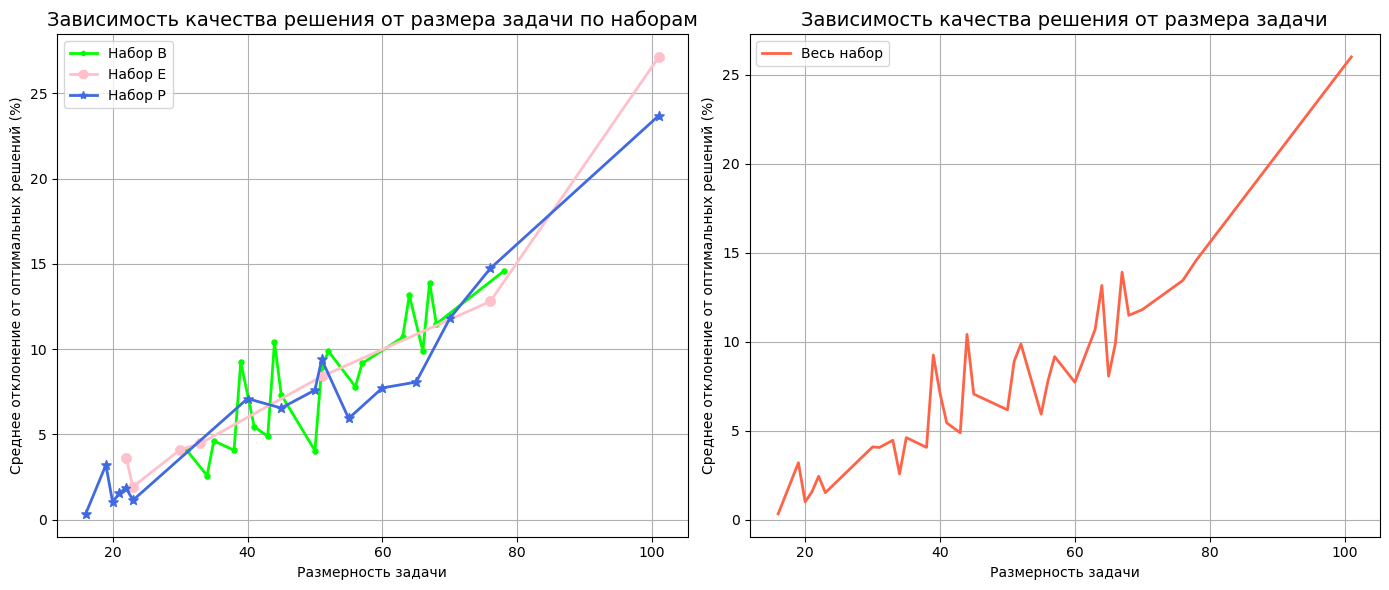

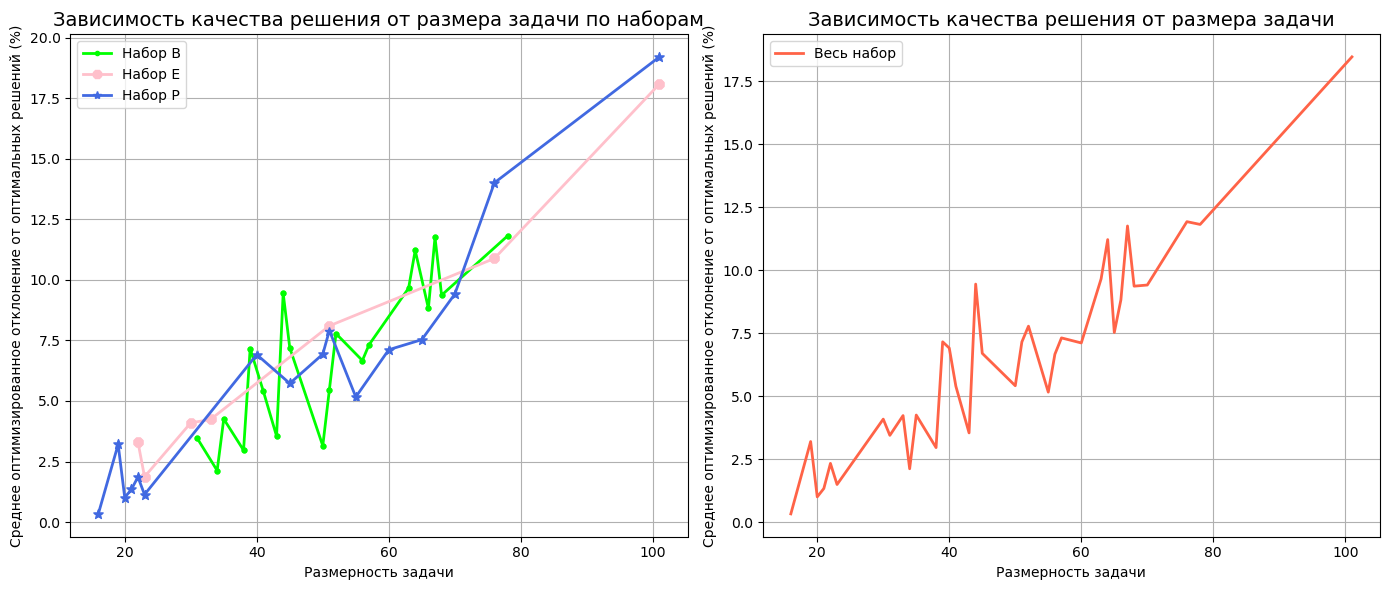

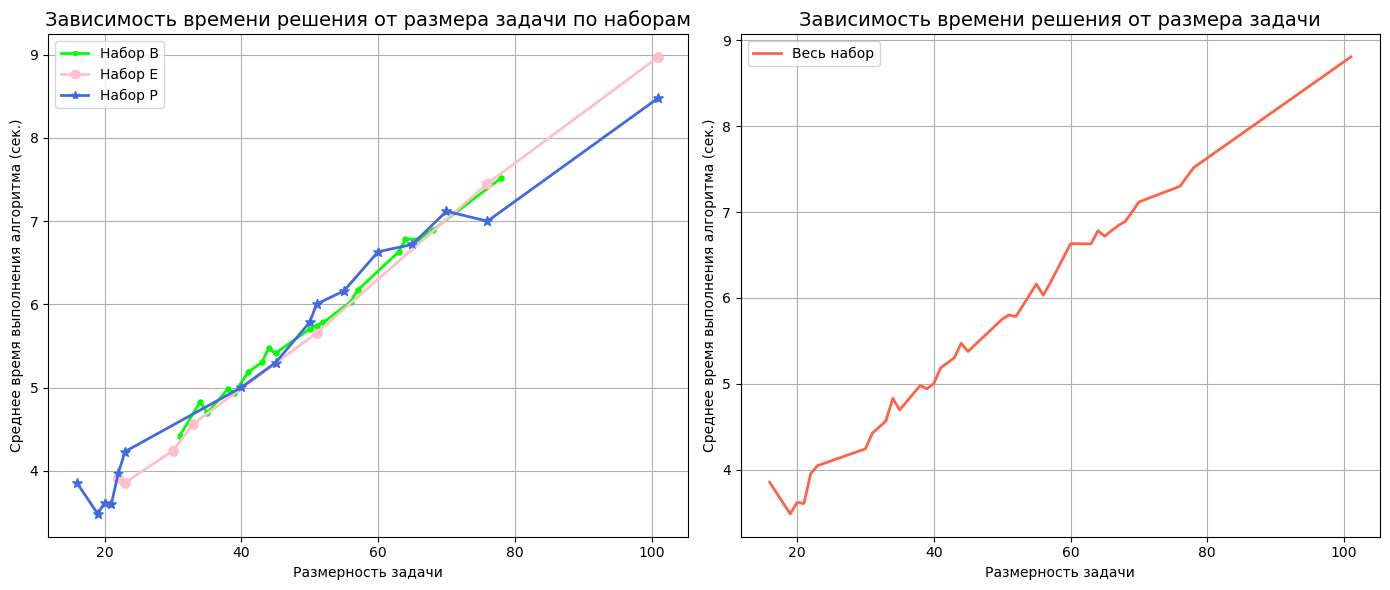

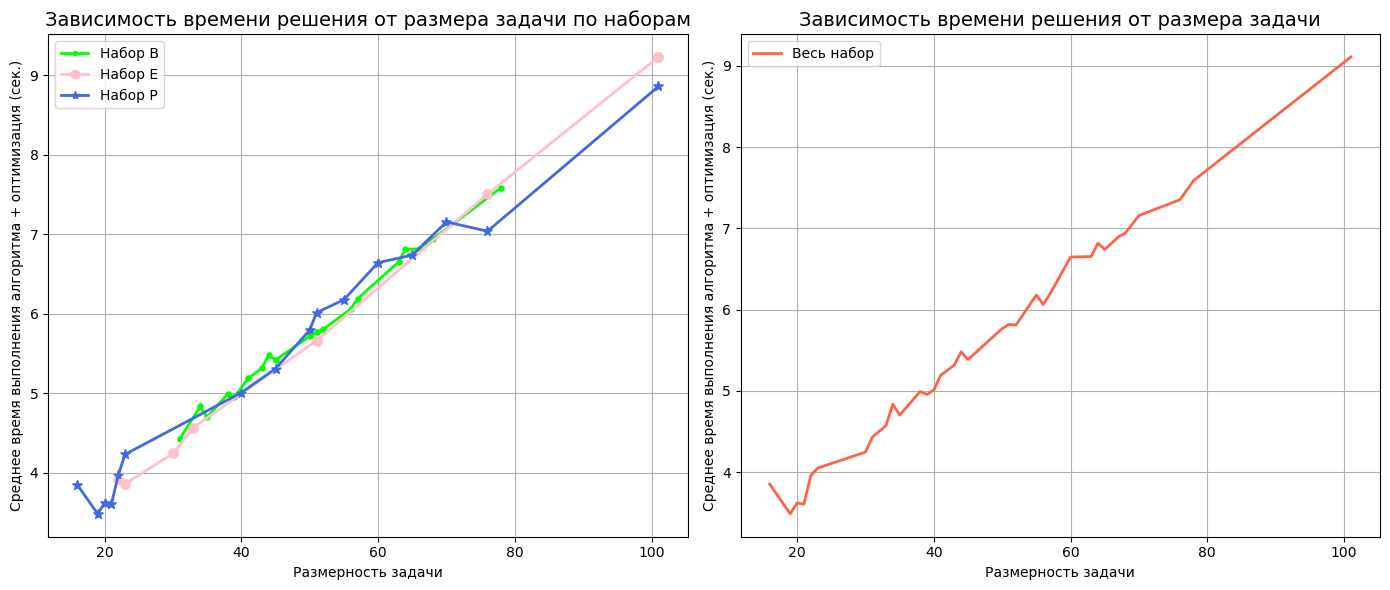

In [699]:
plot_all_graphics(df_300_500_01_09_01)

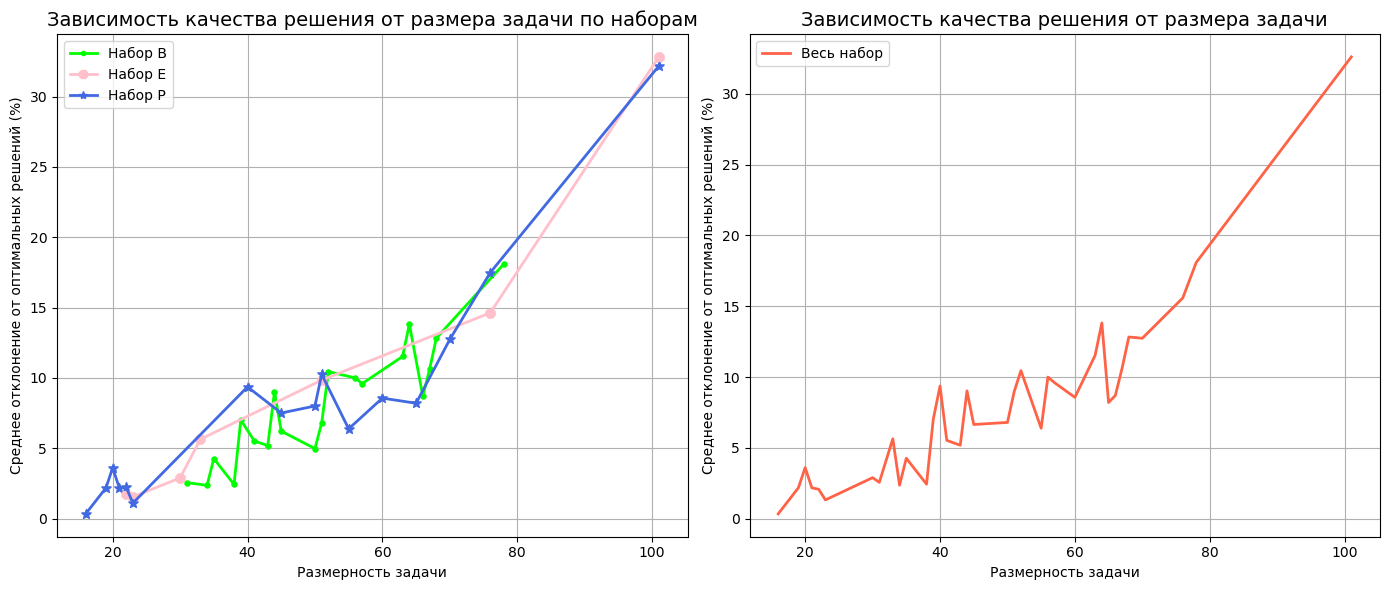

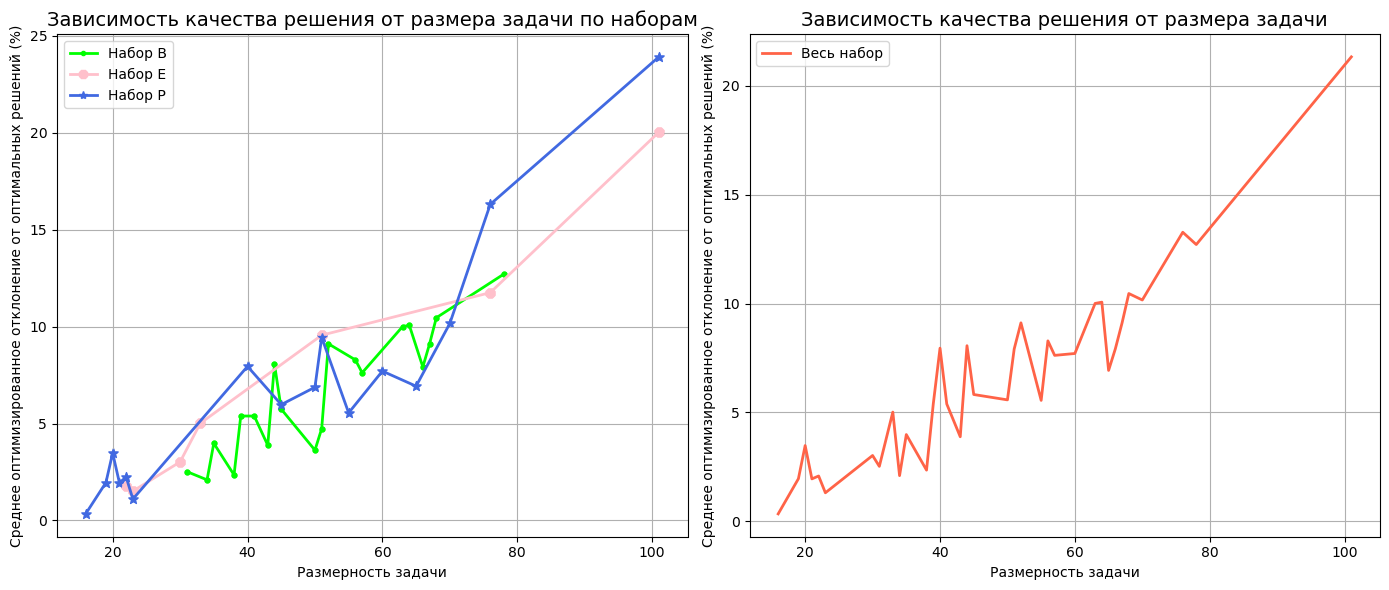

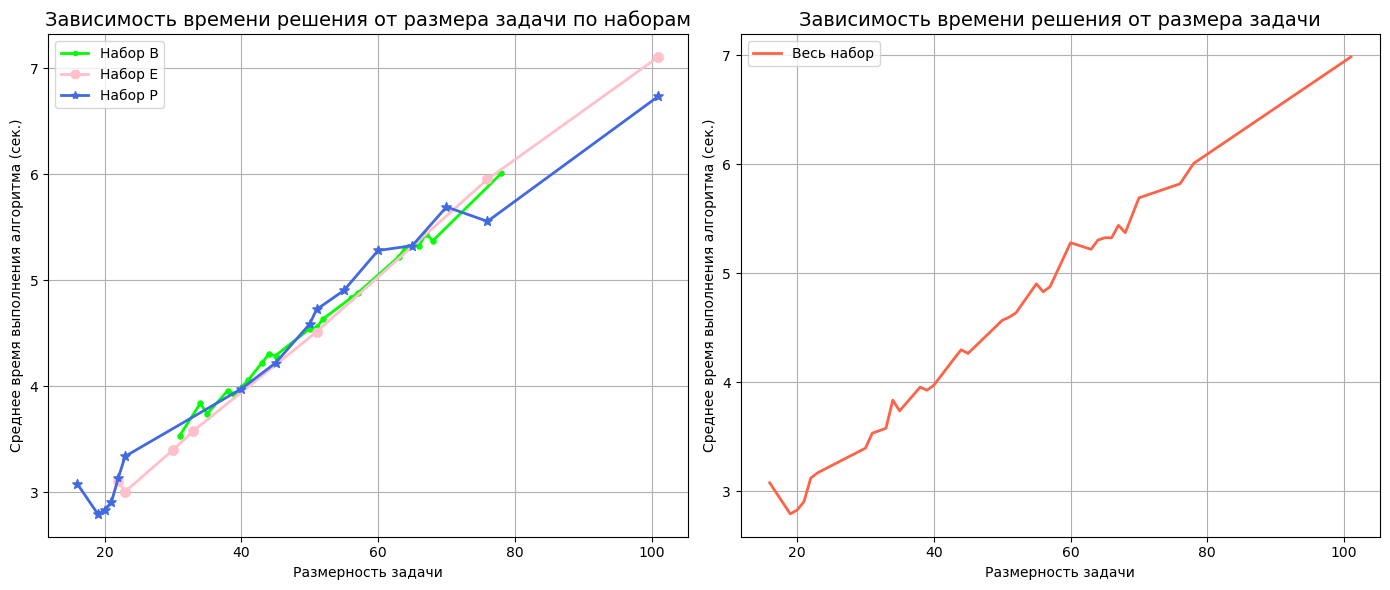

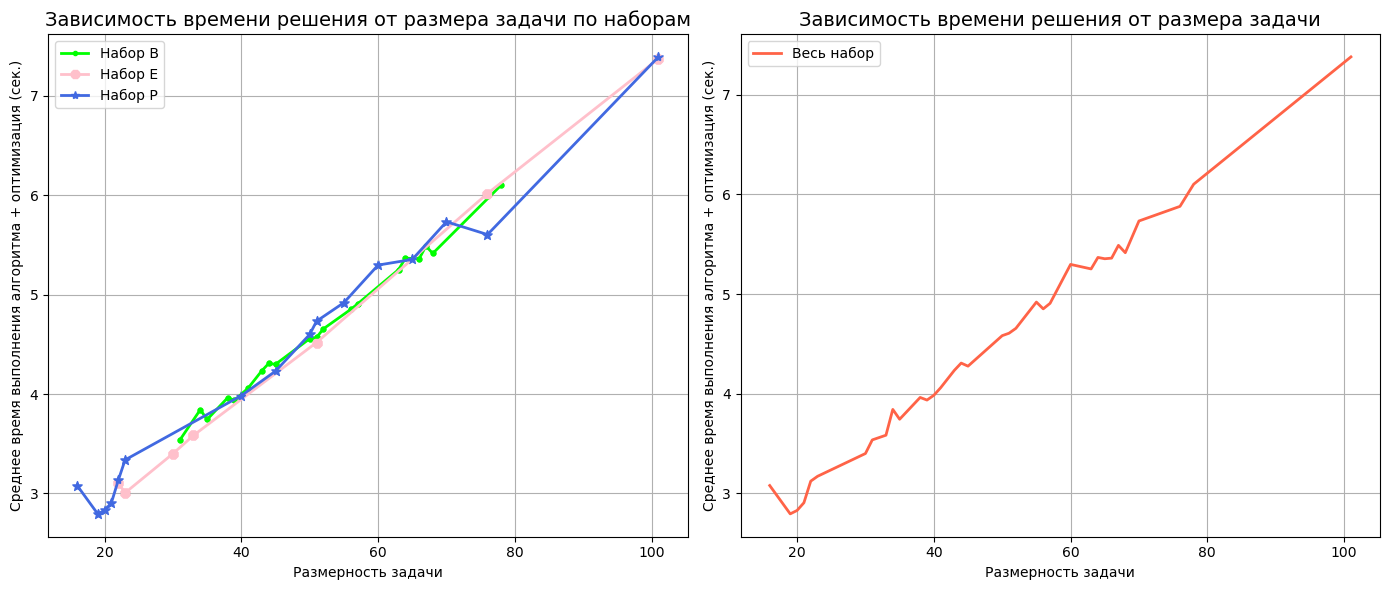

In [652]:
plot_all_graphics(df_300_400_01_09_01)

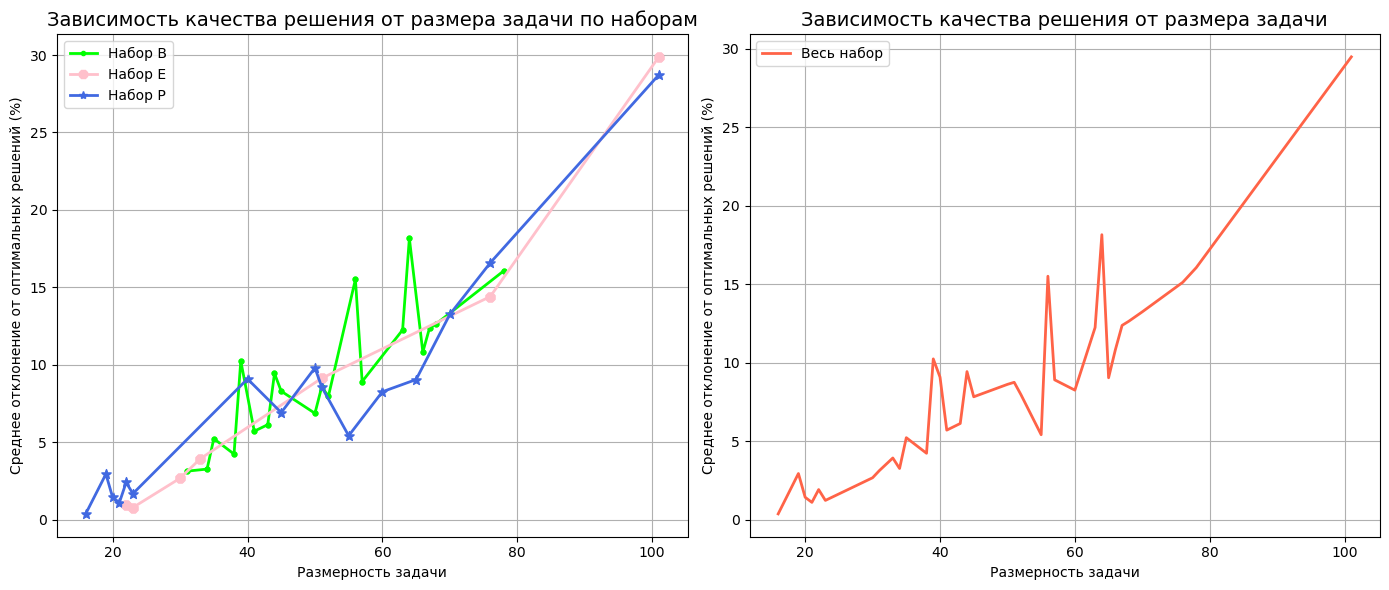

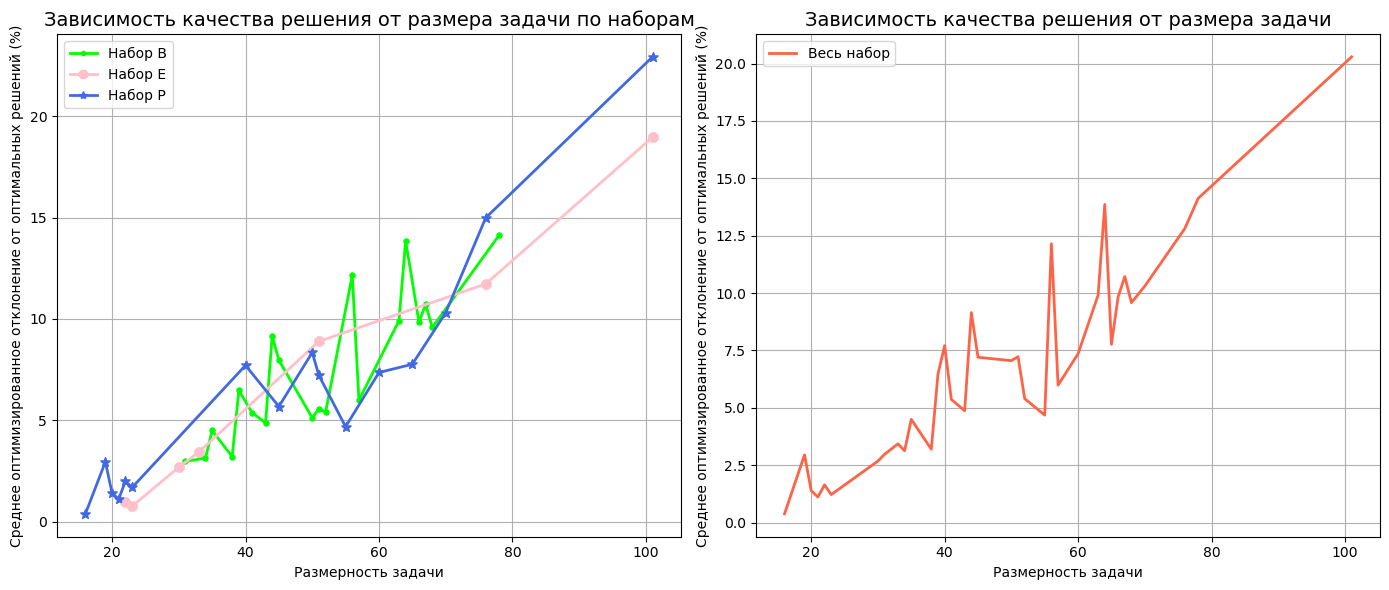

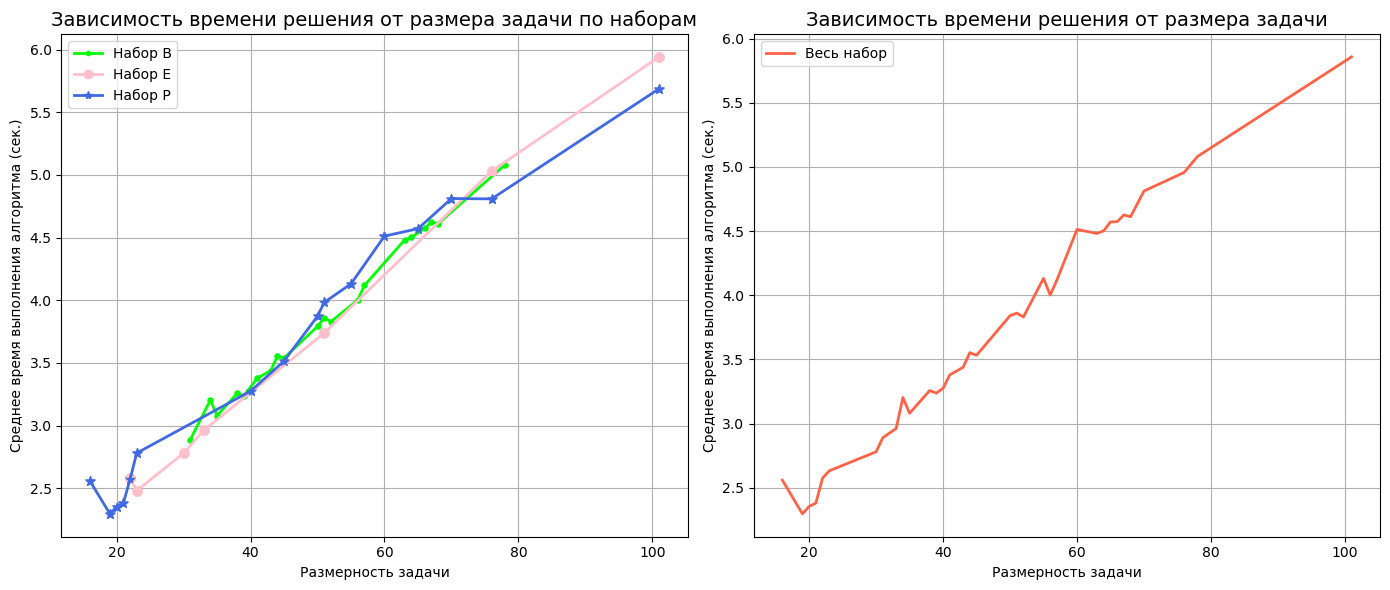

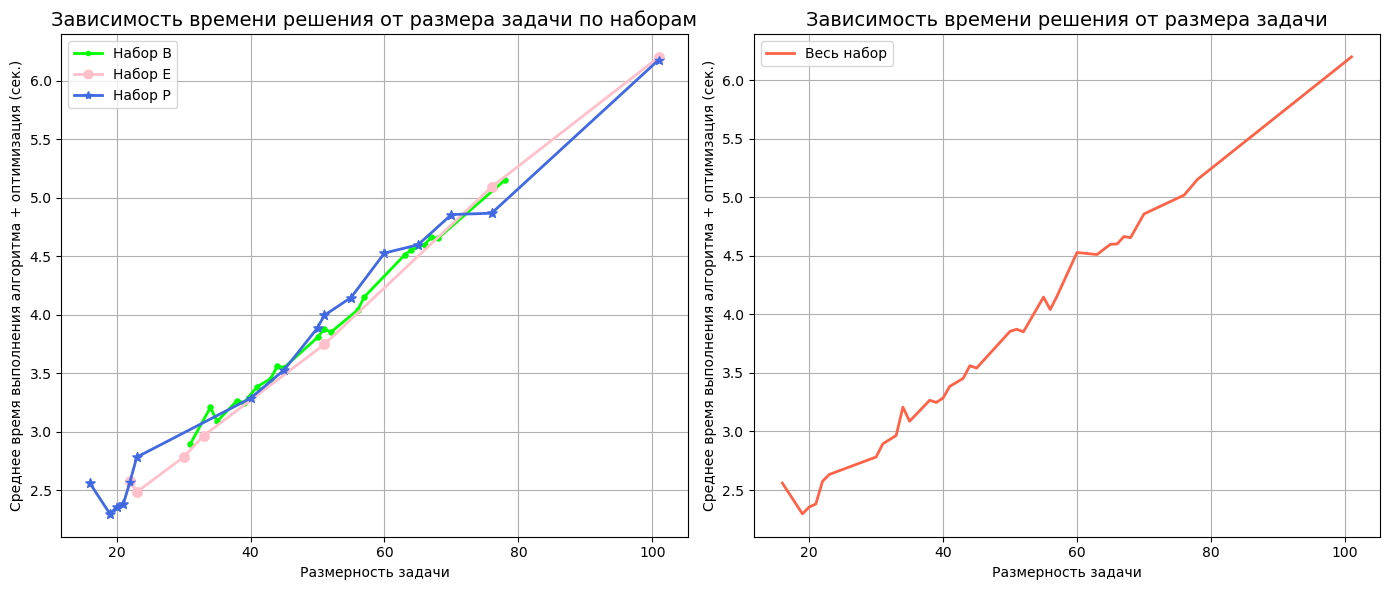

In [653]:
plot_all_graphics(df_200_500_01_09_01)

In [691]:
import matplotlib.pyplot as plt

def plot_average_dataframe(dfs, column_name, x_lab, tit_lab, option=None):
    """
    Строит график зависимости заданной колонки от размера задачи для нескольких датафреймов.

    Входные параметры:
      dfs: список датафреймов
      column_name: имя столбца для анализа
      x_lab: название оси X
      tit_lab: заголовок для графика
      option: дополнительный параметр для группировки
    """
    plt.figure(figsize=(6, 6))
    colors = {0: 'lime', 1: 'pink', 2: 'royalblue'}
    markers = {0: '.', 1: '8', 2: '*'}
    print(option)
    
    # Проходим по каждому датафрейму и строим его график
    for i, df in enumerate(dfs):
        grouped = df.groupby(['file', 'dimension'], as_index=False).mean()
        # Фильтрация датафреймов по условию, если передан параметр с префиксами
        if option == None:
            overall = df.drop(columns=['file']).groupby('dimension', as_index=False).mean()
            population_size = int(overall["population_size"].mean())
            generations = int(overall["generations"].mean())
            selection_rate = round(overall["selection_rate"].mean(), 2)
            mutation_rate = round(overall["mutation_rate"].mean(), 2)
            crossover_prob = round(overall["crossover_prob"].mean(), 2)
            plt.plot(overall['dimension'], overall[column_name], color=colors[i],
                 label=f'Набор {population_size}_{generations}_{selection_rate}_{mutation_rate}_{crossover_prob}',
                      linestyle='-', linewidth=2)
        elif df['file'].iloc[0].startswith(option) != option:
            group = grouped[grouped['file'].str.startswith(option)]
            group = group.drop(columns=['file']).groupby('dimension', as_index=False).mean()
            population_size = int(group["population_size"].mean())
            generations = int(group["generations"].mean())
            selection_rate = round(group["selection_rate"].mean(), 2)
            mutation_rate = round(group["mutation_rate"].mean(), 2)
            crossover_prob = round(group["crossover_prob"].mean(), 2)
            plt.plot(group['dimension'], group[column_name], 
                     label=f'Набор {option}_{population_size}_{generations}_{selection_rate}_{mutation_rate}_{crossover_prob}',
                     color=colors[i], marker=markers[i], linewidth=2)
            plt.scatter(group['dimension'], group[column_name], color=colors[i],
                        marker=markers[i], s=50)

    # Настройка графика
    plt.title(f"Зависимость {tit_lab} решения от размера задачи", fontsize=14)
    plt.xlabel(f"Размерность задачи", fontsize=10)
    plt.ylabel(f"Среднее {x_lab}", fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [692]:
def plot_all_graphics_compar(dfs, option=None):
    columns_df = ['file', 'population_size', 'generations', 'selection_rate', 'mutation_rate', 'crossover_prob', 'dimension', 
              'deviation', 'deviation_opt', 'generated_time', 'optimized_time', 'total_time']
    df1 = dfs[0][columns_df]
    df2 = dfs[1][columns_df]
    df3 = dfs[2][columns_df]
    plot_average_dataframe([df1, df2, df3], 'deviation', 'отклонение от оптимальных решений (%)', 'качества', option)
    plot_average_dataframe([df1, df2, df3], 'deviation_opt', 'оптимизированное отклонение от оптимальных решений (%)', 'качества', option)
    plot_average_dataframe([df1, df2, df3], 'generated_time', 'время выполнения алгоритма (сек.)', 'времени', option)
    plot_average_dataframe([df1, df2, df3], 'total_time', 'время выполнения алгоритма + оптимизация (сек.)', 'времени', option)

B


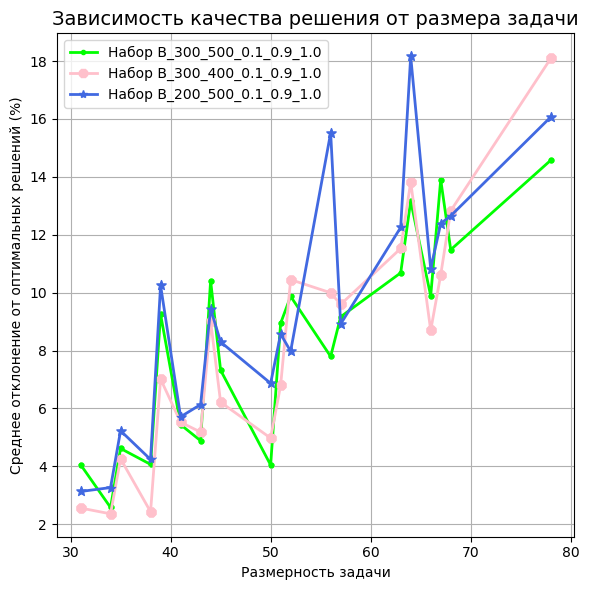

B


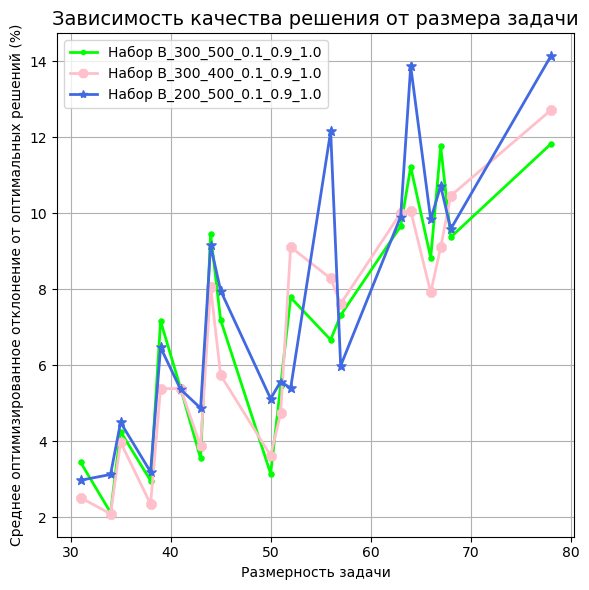

B


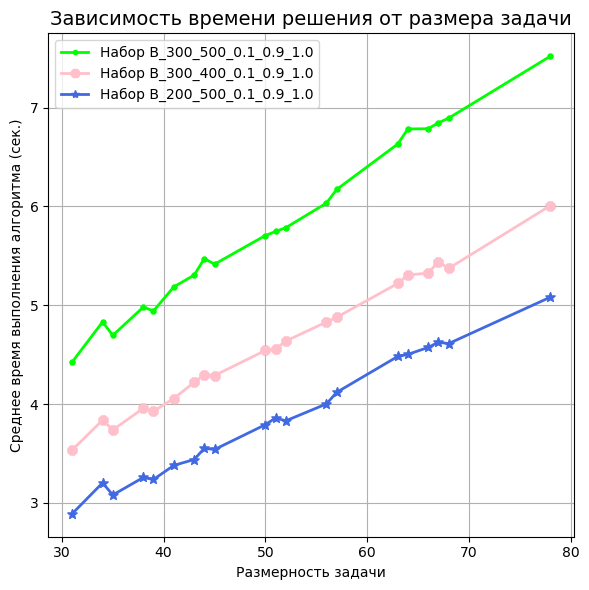

B


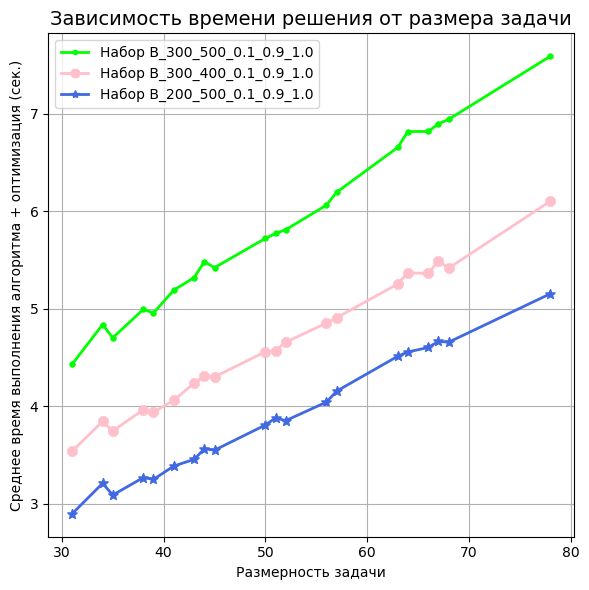

In [693]:
plot_all_graphics_compar([df_300_500_01_09_01, df_300_400_01_09_01, df_200_500_01_09_01], "B")

P


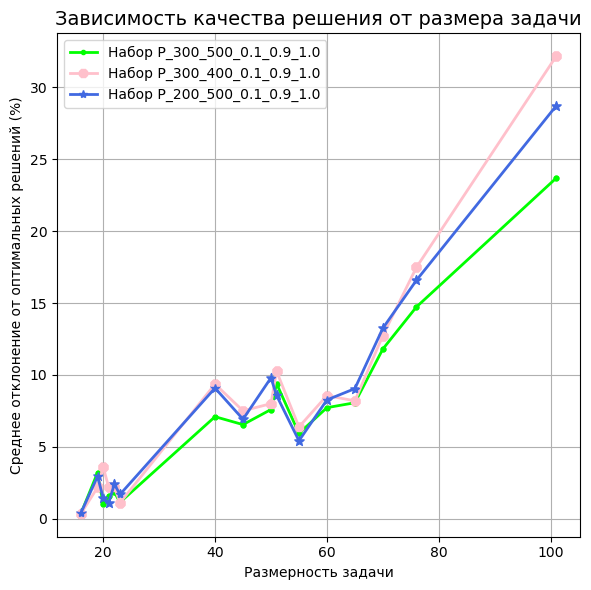

P


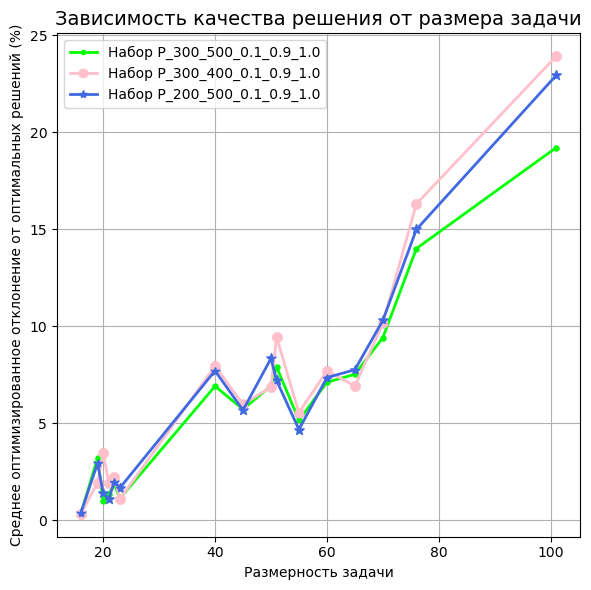

P


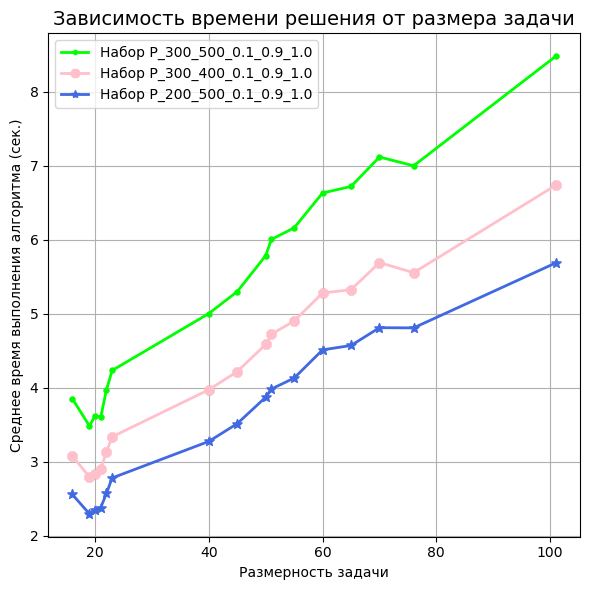

P


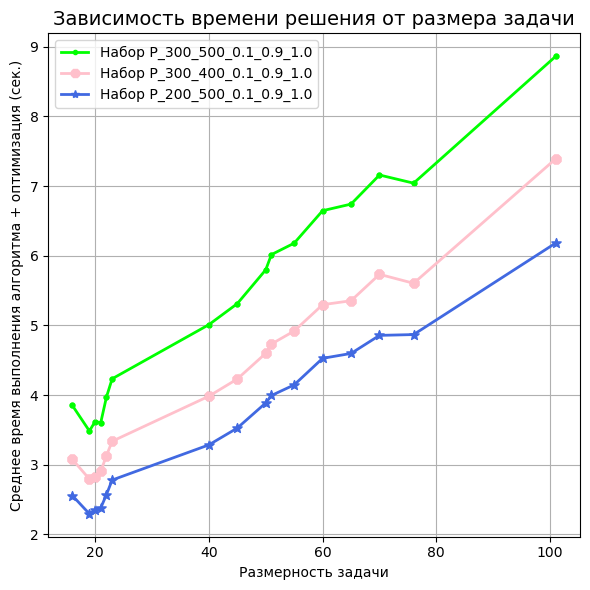

In [694]:
plot_all_graphics_compar([df_300_500_01_09_01, df_300_400_01_09_01, df_200_500_01_09_01], "P")

E


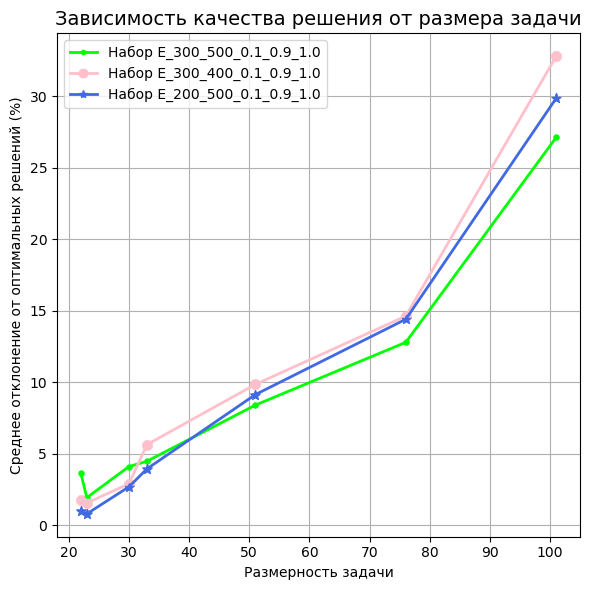

E


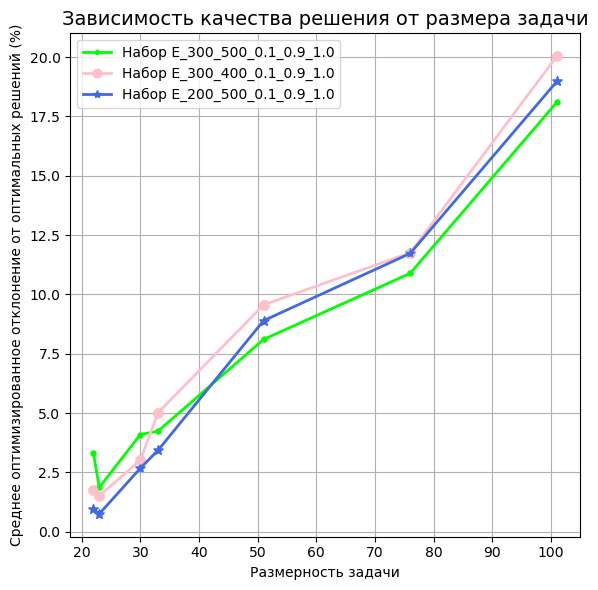

E


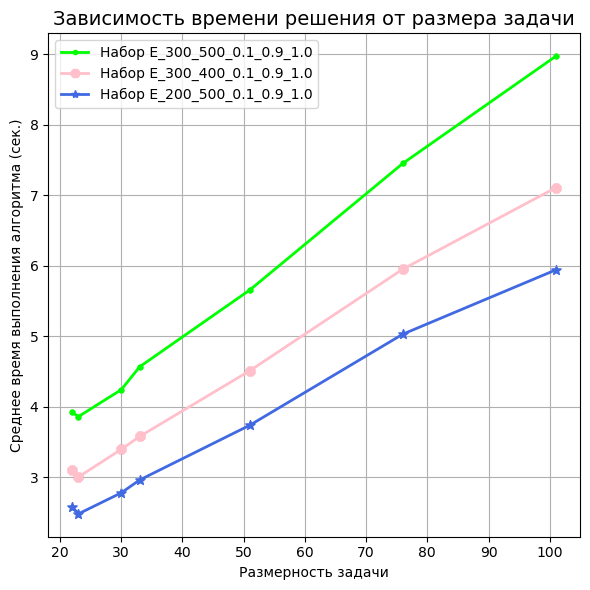

E


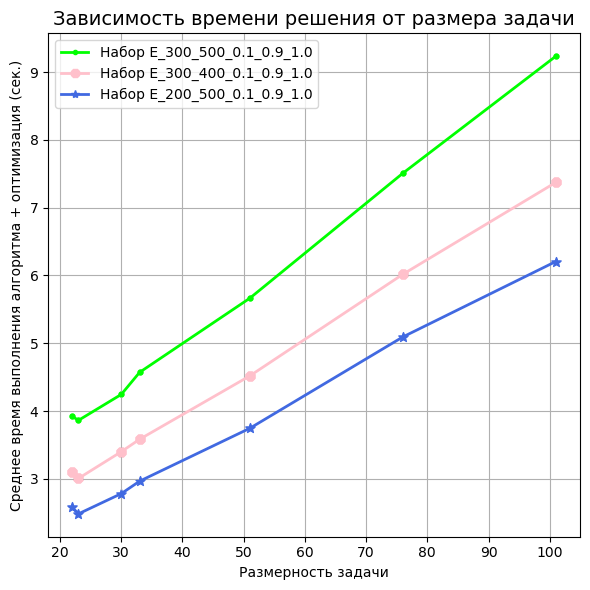

In [695]:
plot_all_graphics_compar([df_300_500_01_09_01, df_300_400_01_09_01, df_200_500_01_09_01], "E")

None


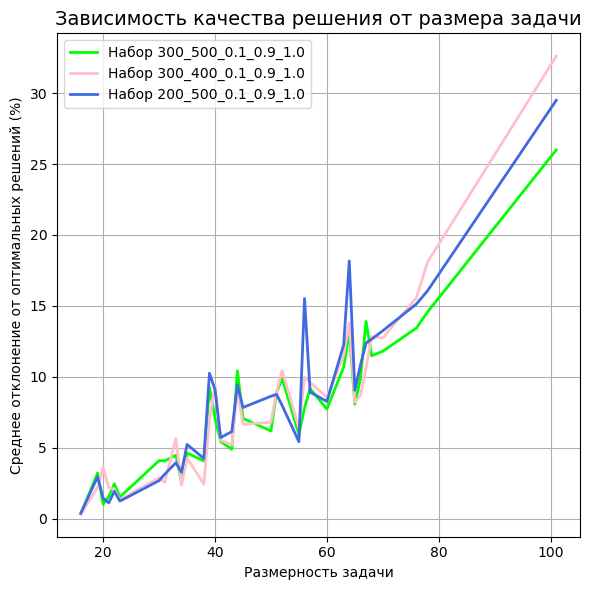

None


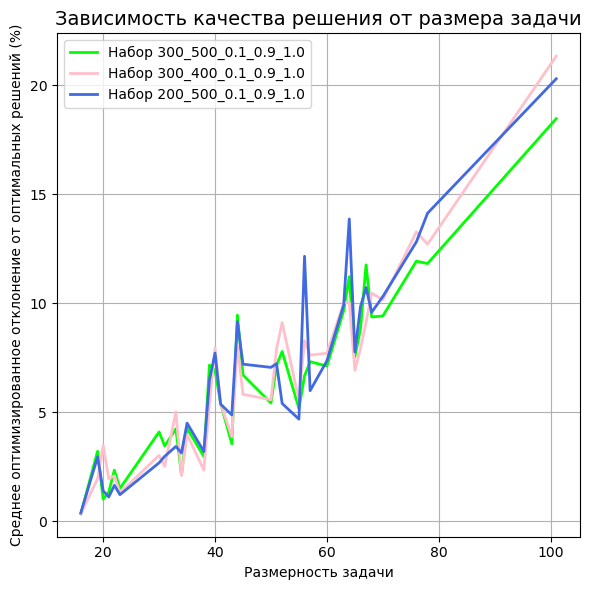

None


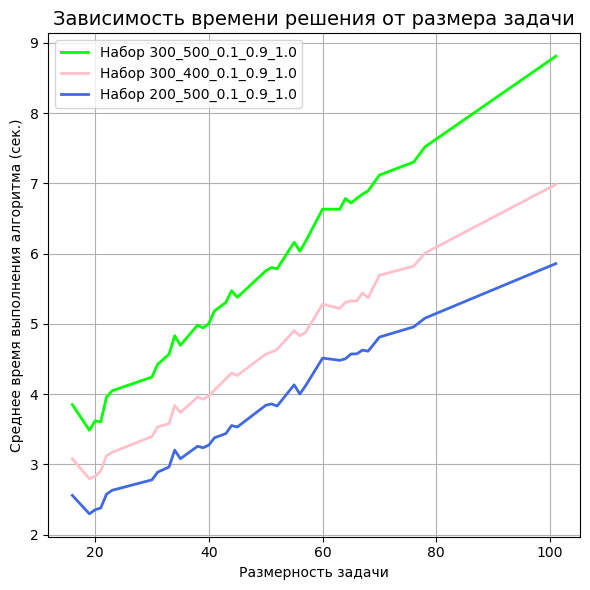

None


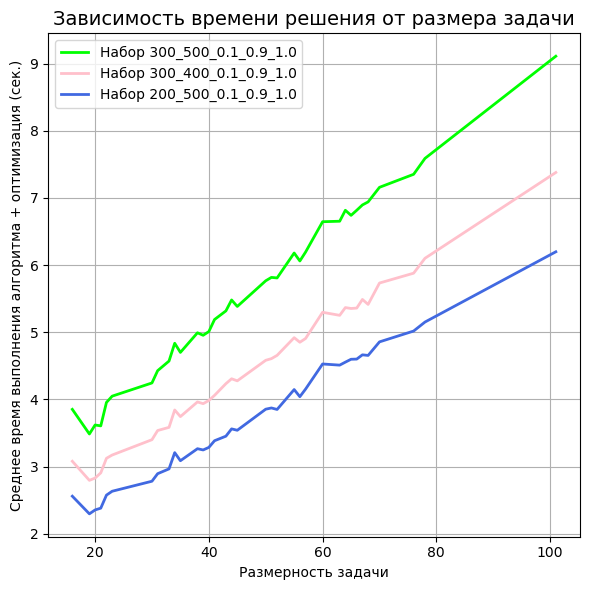

In [696]:
plot_all_graphics_compar([df_300_500_01_09_01, df_300_400_01_09_01, df_200_500_01_09_01], None)

In [722]:
import matplotlib.pyplot as plt
import numpy as np

def plot_paths(coords, generated_routes, optimal_routes, optimized_routes, depot, df):
    """
    Отрисовка маршрутов: найденного, оптимального и оптимизированного.

    Входные параметры:
      coords: координаты вершин
      generated_routes: найденный маршрут
      optimal_routes: оптимальный маршрут
      optimized_routes: оптимизированный маршрут
      depot: депо
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 24))

    # Список маршрутов и их заголовков
    routes_list = [generated_routes, optimal_routes, optimized_routes]
    titles = [f"Найденный маршрут отклонение {round(df['deviation'], 2)}%, стоимость {round(df['generated_cost'], 2)}", 
              f"Оптимальный маршрут стоимость {df['cost']}", 
              f"Оптимизированный маршрут {round(df['deviation_opt'], 2)}%, стоимость {round(df['optimized_cost'], 2)}"]

    for ax, routes, title in zip(axes, routes_list, titles):
        colors = plt.cm.rainbow(np.linspace(0, 1, len(routes)))
        for route, color in zip(routes, colors):
            full_route = [depot] + route + [depot]
            x, y = zip(*[coords[i] for i in full_route])
            ax.plot(x, y, marker='o', color=color)
            
            # Добавление подписей с номерами вершин
            for i, (xi, yi) in enumerate(zip(x, y)):
                if full_route[i] == depot:  # Если текущая вершина — депо
                    ax.text(xi, yi, "Депо", fontsize=8, ha='center', color='black')
                else:
                    ax.text(xi, yi, str(full_route[i]), fontsize=8, ha='center', color='black')

        ax.set_title(title)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid()

    plt.tight_layout()
    plt.show()

In [750]:
all_result = loaded_result_200_500_01_09_01['Тест №2']["E-n101-k8.vrp"]

In [752]:
all_result = loaded_result_300_500_01_09_01['Тест №4']["E-n101-k8.vrp"]

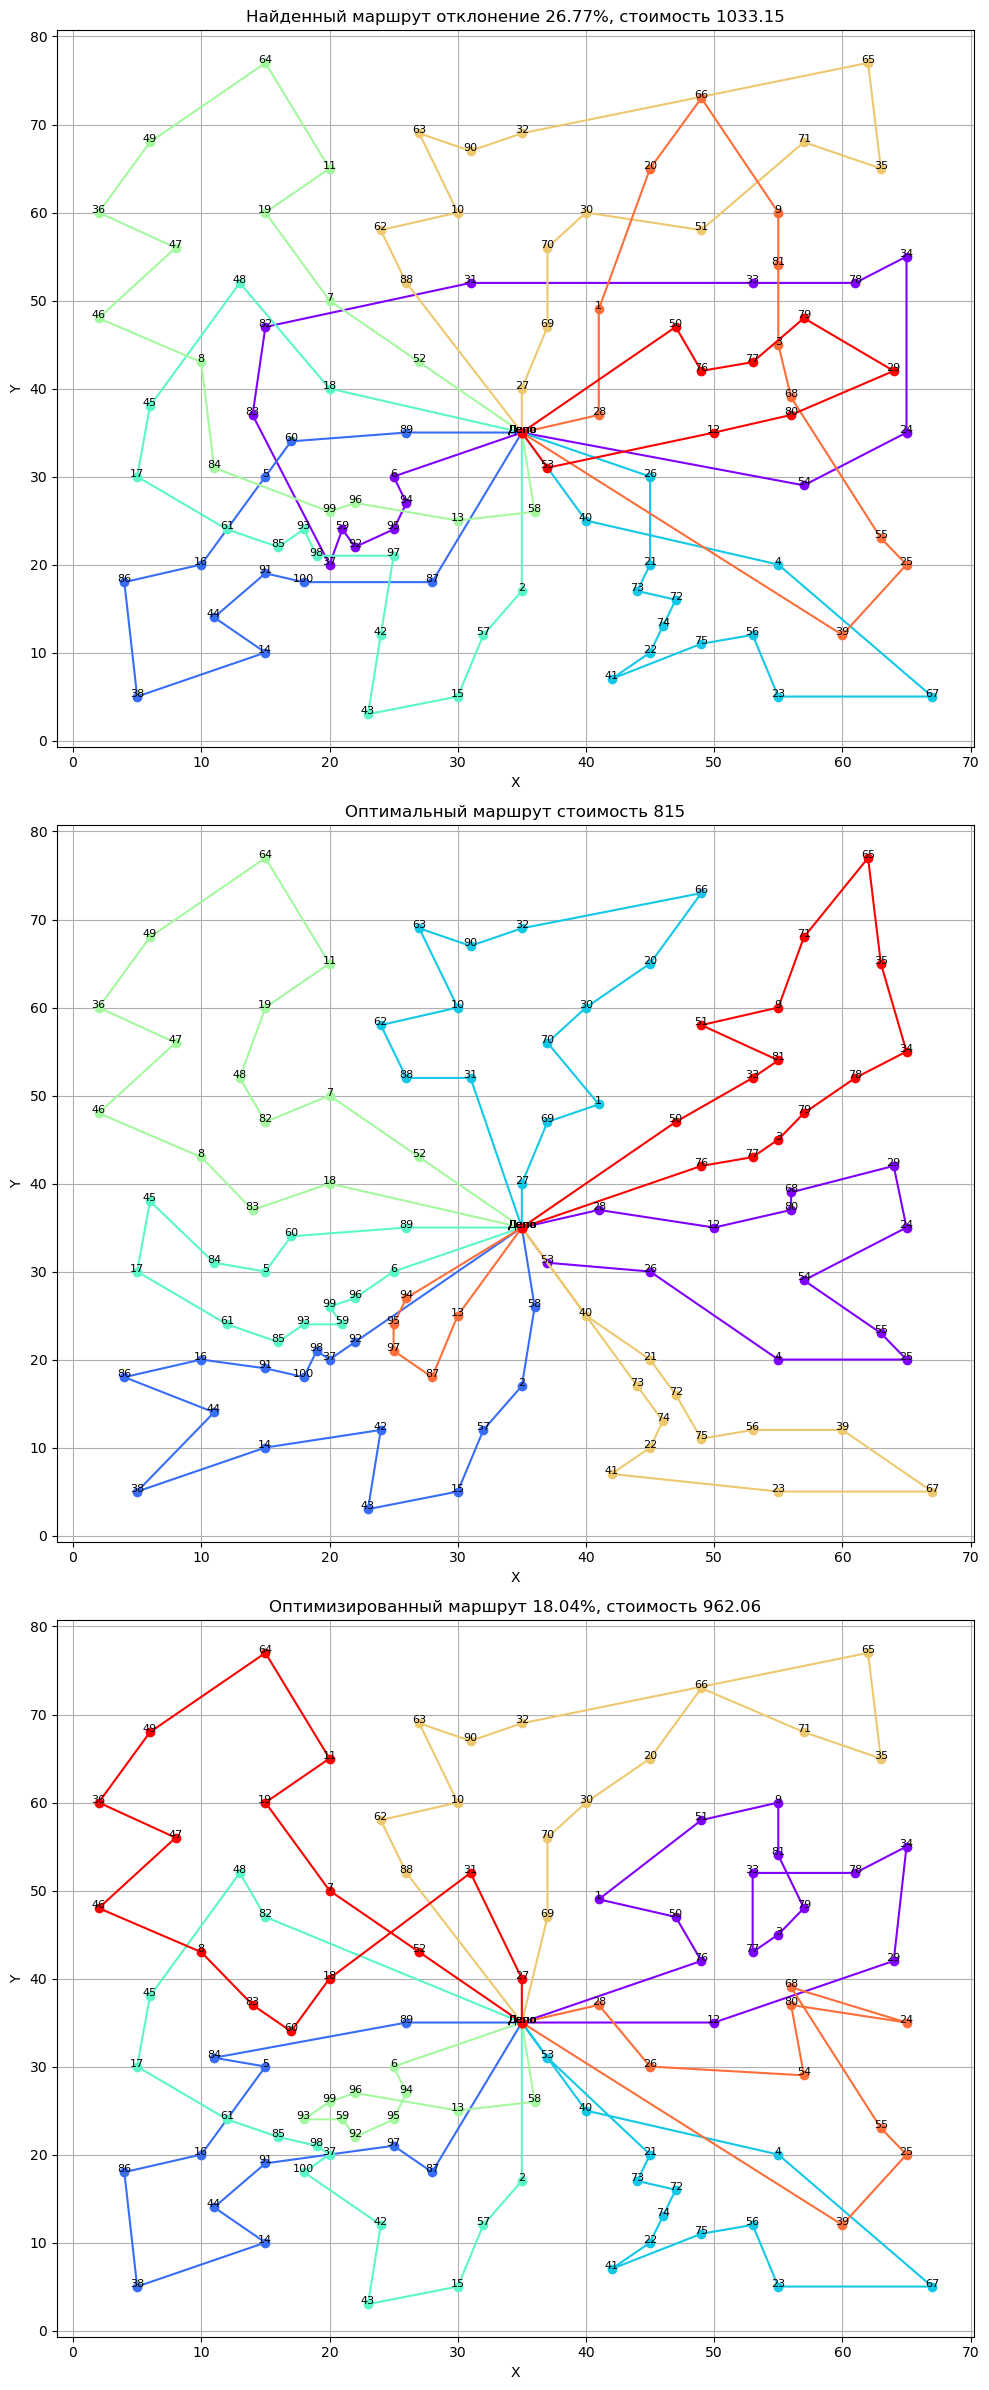

In [753]:
plot_paths(all_result["node_coord"], all_result["generated_routes"], all_result["routes"], 
           all_result["optimized_routes"], all_result["depot"], all_result)